In [65]:
import pandas as pd
import numpy as np
from functools import reduce

# xgb boost
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# causal forest 
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

In [2]:
des_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_descriptive_vars.dta")
ed_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_ed_vars.dta")
inperson_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_inperson_vars.dta")
patterns_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_patterns_vars.dta")
stateprograms_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_stateprograms_vars.dta")
survey0_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_survey0m_vars.dta")
survey6_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_survey6m_vars.dta")
survey12_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_survey12m_vars.dta")

In [3]:
#Descriptive 
des_data = des_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
des_data.replace(-1, np.nan, inplace=True)
des_subdata = des_data[['person_id', 'household_id', 'treatment',
                    'applied_app', 'approved_app', 'postn_death', 'english_list','numhh_list', 
                    'birthyear_list', 'female_list','zip_msa_list']]
des_subdata.loc[:,"numhh_list"] = des_subdata["numhh_list"] + 1



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
# State
stateprograms_data = stateprograms_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
stateprograms_data.replace(-1, np.nan, inplace=True)

In [5]:
# Education
ed_data = ed_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
ed_data.replace(-1, np.nan, inplace=True)


In [6]:
# In Person
inperson_data = inperson_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
inperson_data.replace(-1, np.nan, inplace=True)


In [7]:
# Patterns
patterns_data = patterns_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
patterns_data.replace(-1, np.nan, inplace=True)


In [8]:
# Survey 0
survey0_data = survey0_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
survey0_data.replace(-1, np.nan, inplace=True)


In [9]:
# Survey 6
survey6_data = survey6_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
survey6_data.replace(-1, np.nan, inplace=True)


In [10]:
# Survey 12
survey12_data = survey12_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
survey12_data.replace(-1, np.nan, inplace=True)


In [11]:
dfs = [des_subdata, stateprograms_data, ed_data, inperson_data, patterns_data, survey0_data, survey6_data, survey12_data]
merged = reduce(lambda left, right: pd.merge(left, right, on='person_id', how='outer'), dfs)

In [12]:
df_filtered = merged.filter(regex='^(?!.*_y$)')
df_filtered = df_filtered.rename(lambda x: x.replace('_x', ''), axis=1)
df_filtered = df_filtered.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == 'object' else x)
datetime_columns = df_filtered.select_dtypes('datetime64[ns]').columns
ordinal_encoder = OrdinalEncoder()
df_filtered[datetime_columns] = ordinal_encoder.fit_transform(df_filtered[datetime_columns])


In [13]:
outcome1 = ['happiness_12m', 'health_gen_bin_12m', 'health_chg_bin_12m', 
             'baddays_phys_12m', 'baddays_ment_12m', 'health_work_12m', 
             'dep_interest_12m', 'dep_sad_12m'] 

outcome2 = ['cost_any_oop_12m', 'cost_tot_oop_12m', 'cost_any_owe_12m', 
             'cost_tot_owe_12m', 'cost_borrow_12m', 'cost_refused_12m'] 

outcome3 = ['rx_any_12m', 'rx_num_mod_12m', 'doc_any_12m', 'doc_num_mod_12m', 
             'er_any_12m', 'er_num_mod_12m', 'hosp_any_12m' , 'hosp_num_mod_12m']

outcomes = outcome1 + outcome2 + outcome3
        
remove = list(survey12_data.columns)

# Boost

## Outcome 1

In [14]:
df = df_filtered.dropna(subset= outcome1)

X1 = df.drop(columns= ['person_id','household_id', 'ohp_all_ever_matchn_30sep2009','birthyear_0m'] + outcomes + remove)  

y1 = df[outcome1]

In [15]:
model1 = xgb.XGBRegressor(objective='reg:squarederror')
model1.fit(X1, y1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

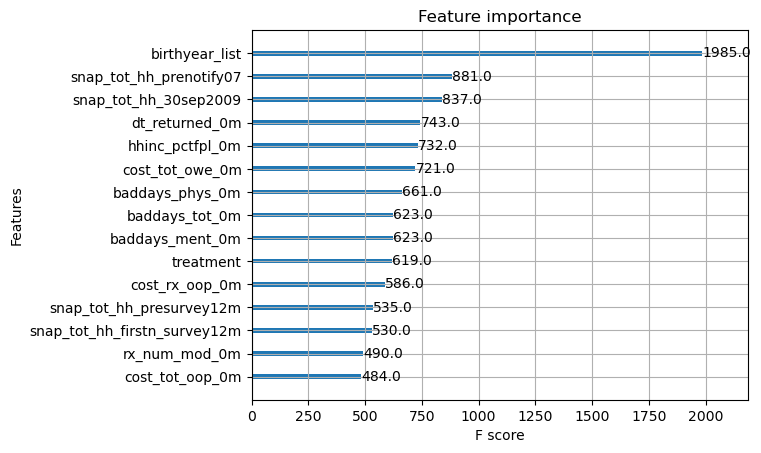

In [16]:
xgb.plot_importance(model1,max_num_features=15)

## Outcome 2

In [17]:
df = df_filtered.dropna(subset= outcome2)

X2 = df.drop(columns= ['person_id','household_id', 'ohp_all_ever_matchn_30sep2009', 'birthyear_0m'] + outcomes + remove)  

y2 = df[outcome2]


In [18]:
model2 = xgb.XGBRegressor(objective='reg:squarederror')
model2.fit(X2, y2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

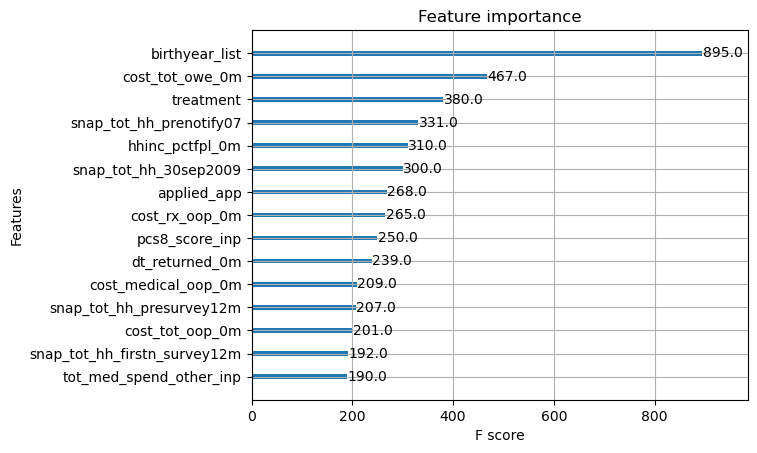

In [19]:
xgb.plot_importance(model2,max_num_features=15)

## Outcome 3

In [20]:
df = df_filtered.dropna(subset= outcome3)

X3 = df.drop(columns= ['person_id','household_id', 'ohp_all_ever_matchn_30sep2009', 'birthyear_0m'] + outcomes + remove)  

y3 = df[outcome3]


In [21]:
model3 = xgb.XGBRegressor(objective='reg:squarederror')
model3.fit(X3, y3)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

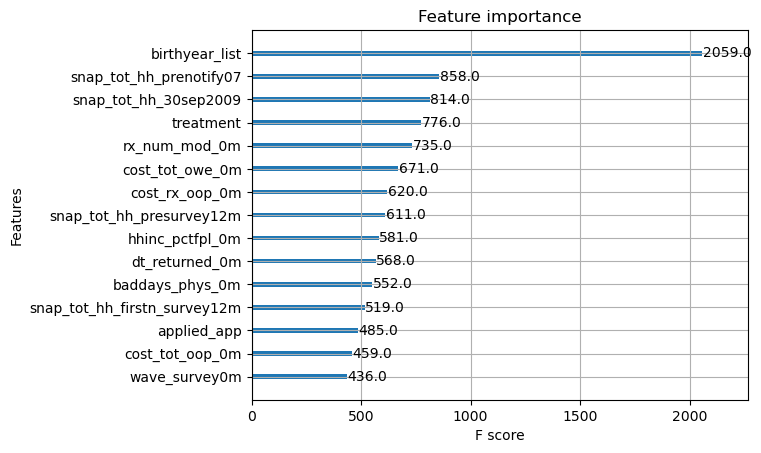

In [22]:
xgb.plot_importance(model3,max_num_features=15)

In [23]:
np.sort(model3.feature_importances_, )

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       2.9307617e-05, 5.0199487e-05, 5.6101358e-05, 6.0257164e-05,
       6.9215435e-05, 6.9850590e-05, 9.7446384e-05, 9.9082332e-05,
       1.0576325e-04, 1.1951132e-04, 1.3981358e-04, 1.3988694e-04,
       1.4069698e-04, 1.4418986e-04, 1.4475723e-04, 1.4951320e-04,
       1.5397106e-04, 1.5752461e-04, 1.6550797e-04, 1.6585170e-04,
       1.8933786e-04, 1.9253255e-04, 1.9374206e-04, 1.9600816e-04,
       2.1055280e-04, 2.1107489e-04, 2.1992956e-04, 2.3534313e

In [24]:
n = 100

thresh = 300

importances = model1.get_booster().get_score(importance_type='weight')
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

top1n = [feature for feature, x in sorted_importances[:n] if x > thresh]
top1 = [X1.columns.get_loc(feature) for feature in top1n]
        
importances = model2.get_booster().get_score(importance_type='weight')
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

top2n = [feature for feature, x in sorted_importances[:n] if x > thresh]
top2 = [X2.columns.get_loc(feature) for feature in top2n]


importances = model2.get_booster().get_score(importance_type='weight')
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

top3n = [feature for feature, x in sorted_importances[:n] if x > thresh]
top3 = [X3.columns.get_loc(feature) for feature in top3n]


In [25]:
top_feat = np.unique(top1n + top2n + top3n)
top_feat = [str(x) for x in top_feat]
top_feat



['applied_app',
 'baddays_ment_0m',
 'baddays_phys_0m',
 'baddays_tot_0m',
 'birthyear_list',
 'bmi_inp',
 'cost_medical_oop_0m',
 'cost_rx_oop_0m',
 'cost_tot_oop_0m',
 'cost_tot_oop_correct_0m',
 'cost_tot_owe_0m',
 'doc_num_mod_0m',
 'dt_returned_0m',
 'hdl_inp',
 'health_gen_0m',
 'hhinc_cat_0m',
 'hhinc_pctfpl_0m',
 'hhsize_0m',
 'living_arrange_0m',
 'mcs8_score_inp',
 'numhh_list',
 'pcs8_score_inp',
 'phqtot_inp',
 'rx_num_mod_0m',
 'snap_tot_hh_30sep2009',
 'snap_tot_hh_firstn_survey12m',
 'snap_tot_hh_prenotify07',
 'snap_tot_hh_presurvey12m',
 'treatment',
 'usual_care_0m',
 'wave_survey0m',
 'weight_total_inp']

In [26]:
df = df_filtered[['person_id','household_id', 'ohp_all_ever_matchn_30sep2009','sample_12m_resp'] + outcomes + top_feat]

In [27]:
sample = df[df['sample_12m_resp'] == 1].drop(columns = 'sample_12m_resp')

In [28]:
sample.describe()

,person_id,household_id,ohp_all_ever_matchn_30sep2009,happiness_12m,health_gen_bin_12m,health_chg_bin_12m,baddays_phys_12m,baddays_ment_12m,health_work_12m,dep_interest_12m,...,phqtot_inp,rx_num_mod_0m,snap_tot_hh_30sep2009,snap_tot_hh_firstn_survey12m,snap_tot_hh_prenotify07,snap_tot_hh_presurvey12m,treatment,usual_care_0m,wave_survey0m,weight_total_inp
count,23741.000000,23741.000000,23741.000000,23416.000000,23361.000000,23407.000000,21384.00000,21601.000000,23324.000000,23326.000000,...,5721.000000,15317.000000,23741.000000,23741.000000,23741.000000,23741.000000,23741.000000,10473.000000,23741.000000,7939.000000
mean,37296.851562,140986.390625,0.276821,1.263495,0.430504,0.270047,9.50463,11.027267,0.400575,1.016677,...,6.801608,1.693543,1927.297713,2244.720568,1438.238785,1120.815930,0.497367,1.631529,3.438482,0.984675
std,21612.953125,21296.521484,0.447437,0.658531,0.495157,0.443994,10.85554,11.266710,0.490025,1.049320,...,5.898790,2.550425,2329.711310,2648.194507,1890.788329,1539.088475,0.500004,1.846193,2.076460,0.850123
min,1.000000,100001.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18525.000000,123327.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.895068
50%,37230.000000,142872.000000,0.000000,1.000000,0.000000,0.000000,5.00000,7.000000,0.000000,1.000000,...,5.000000,0.000000,1253.000000,1532.000000,700.000000,324.000000,0.000000,1.000000,4.000000,1.000000
75%,56005.000000,159404.000000,1.000000,2.000000,1.000000,1.000000,15.00000,20.000000,1.000000,2.000000,...,10.000000,3.000000,2988.000000,3390.000000,2367.000000,1983.000000,1.000000,3.000000,5.000000,1.159381
max,74921.000000,174921.000000,1.000000,2.000000,1.000000,1.000000,30.00000,30.000000,1.000000,3.000000,...,24.000000,23.000000,19351.000000,24374.000000,20745.000000,15190.000000,1.000000,6.000000,7.000000,13.266743


In [29]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23741 entries, 0 to 74920
Data columns (total 57 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   person_id                      23741 non-null  float32
 1   household_id                   23741 non-null  float32
 2   ohp_all_ever_matchn_30sep2009  23741 non-null  int8   
 3   happiness_12m                  23416 non-null  float64
 4   health_gen_bin_12m             23361 non-null  float64
 5   health_chg_bin_12m             23407 non-null  float64
 6   baddays_phys_12m               21384 non-null  float64
 7   baddays_ment_12m               21601 non-null  float64
 8   health_work_12m                23324 non-null  float64
 9   dep_interest_12m               23326 non-null  float64
 10  dep_sad_12m                    23371 non-null  float64
 11  cost_any_oop_12m               23426 non-null  float64
 12  cost_tot_oop_12m               22731 non-null 

In [ ]:
# sample.to_csv('sample.csv', index = False)

In [212]:
sample['cost_tot_owe_12m'].describe()

count    1.919500e+04
mean     5.731461e+07
std      7.939973e+09
min      0.000000e+00
25%      0.000000e+00
50%      5.000000e+01
75%      1.000000e+03
max      1.100075e+12
Name: cost_tot_owe_12m, dtype: float64

## Looking for HTE

In [207]:
trial = sample.groupby(top_feat)
trial = trial[outcomes].agg('mean')

In [ ]:
#trial.reset_index().to_csv('trial.csv', index = False)

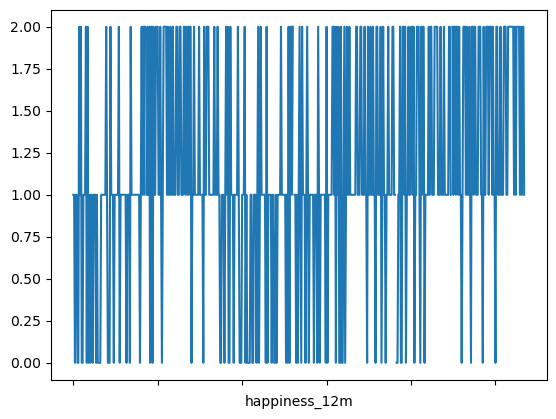

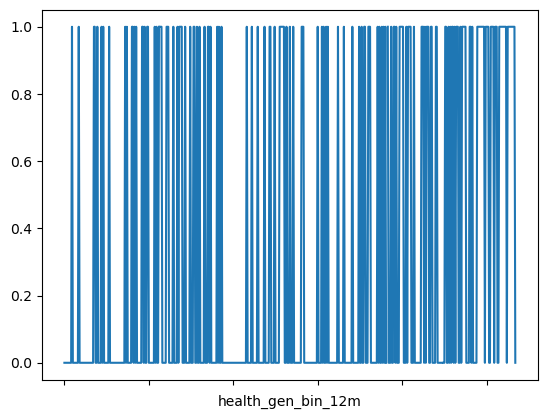

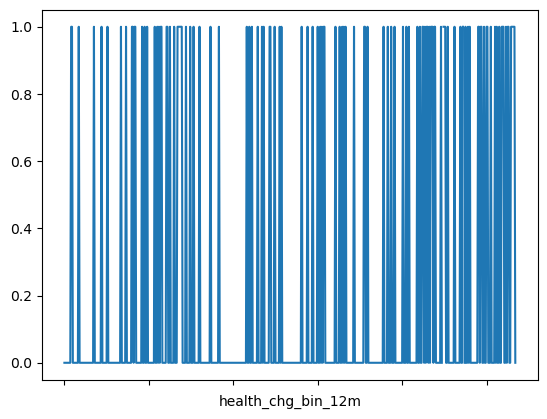

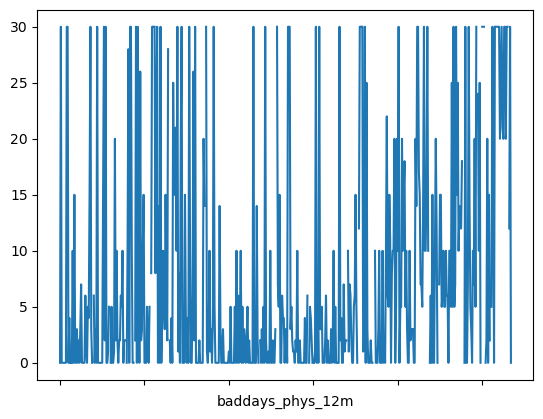

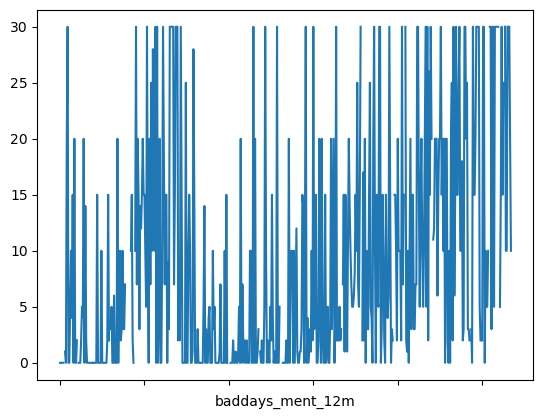

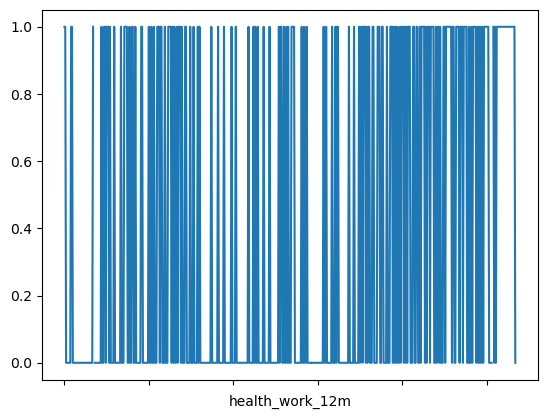

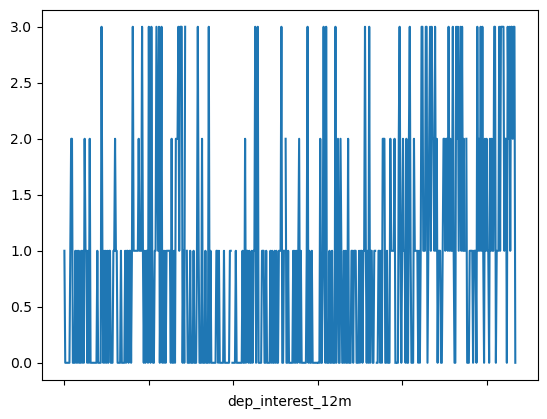

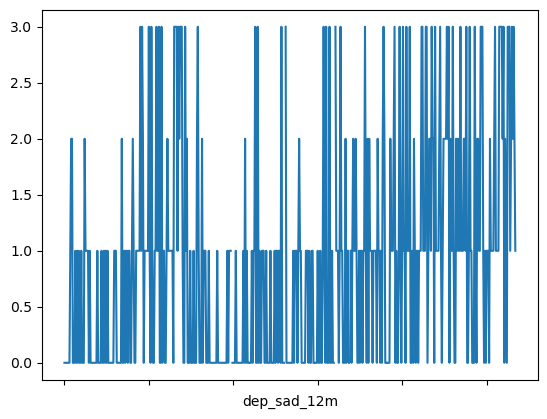

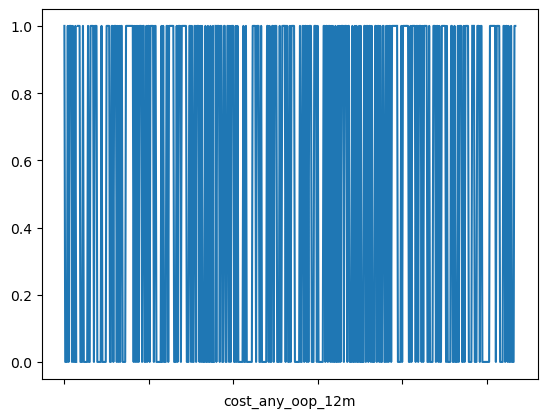

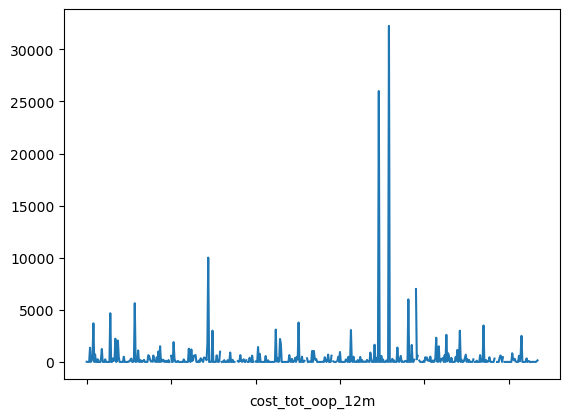

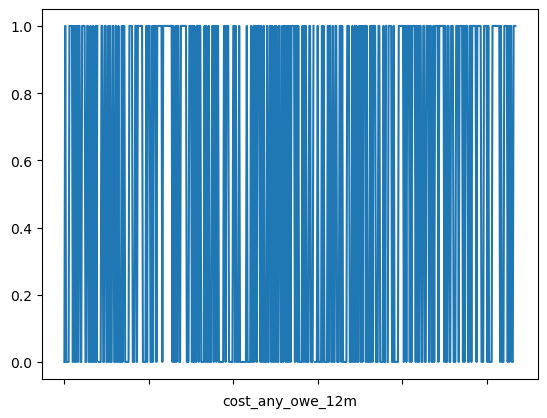

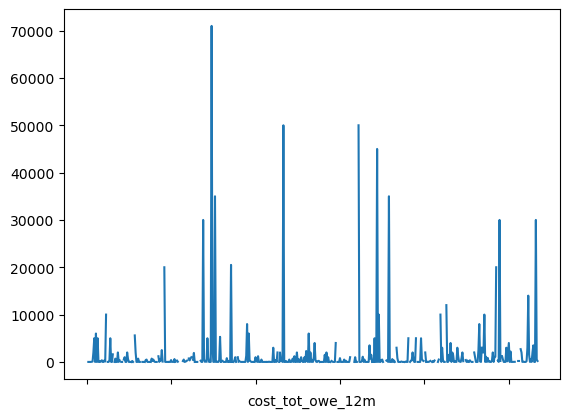

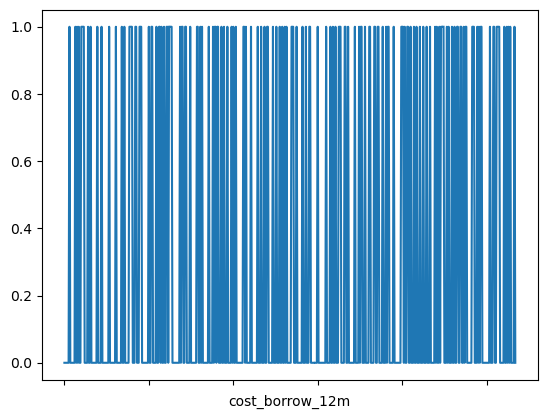

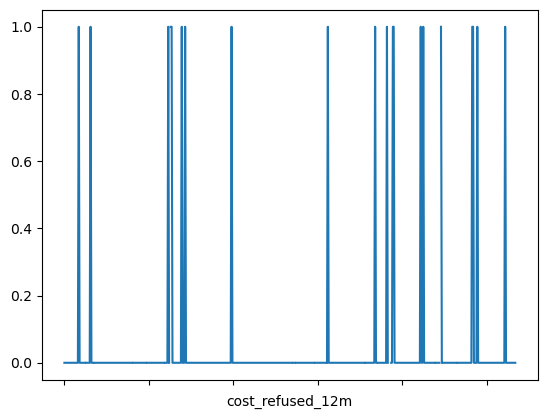

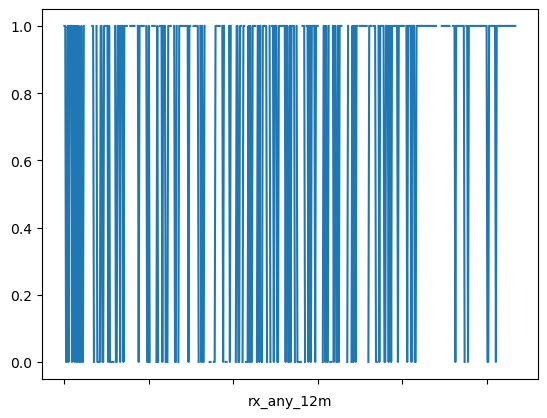

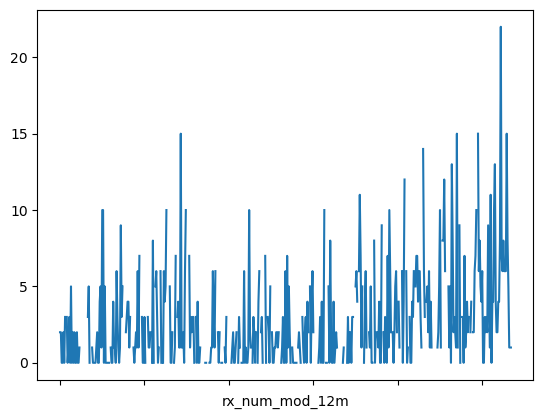

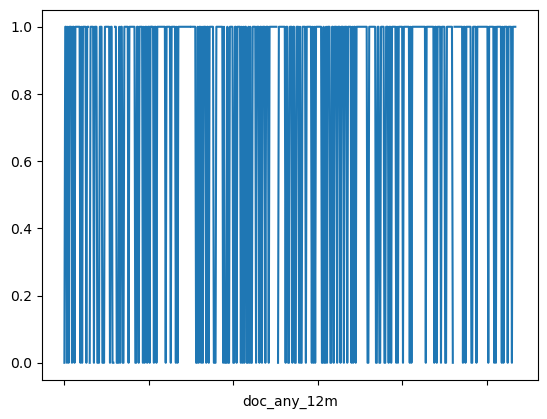

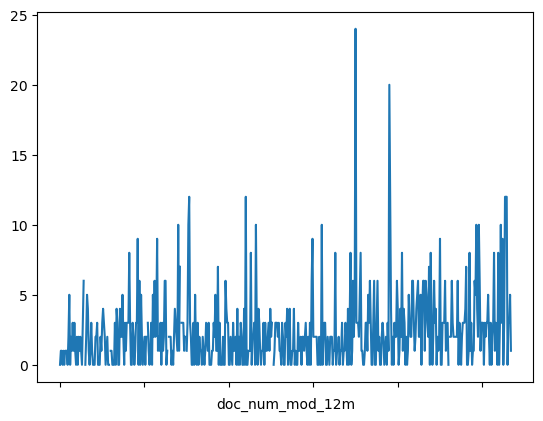

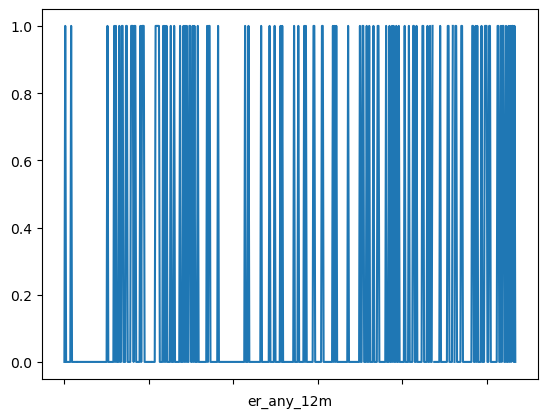

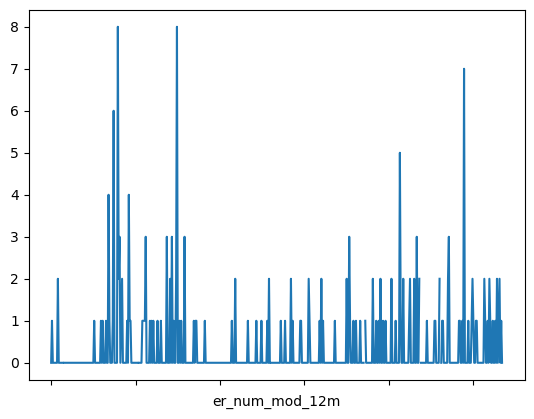

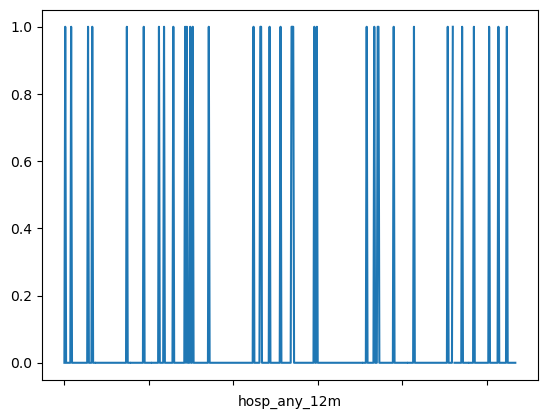

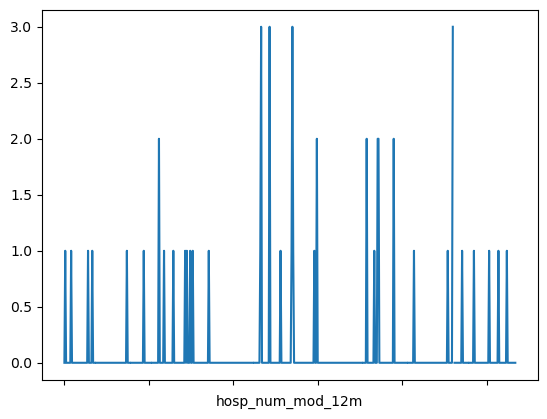

In [208]:
for name in outcomes:
    ax = trial[name].plot()

    ax.set_xticklabels([])

    ax.set_xlabel(str(name))

    plt.show()

## Propensity for different groups

In [32]:
trial = sample.groupby(top_feat)


In [33]:
trial = trial['ohp_all_ever_matchn_30sep2009'].agg('mean')



In [34]:
trial.reset_index().to_csv('trial2.csv', index = False)

In [35]:
prop = pd.read_csv(r'trial2.csv')

In [36]:
from sklearn.cluster import KMeans

In [40]:
data_columns = prop.columns[:32]

# Use KMeans clustering to create bins
kmeans = KMeans(n_clusters=10, n_init = "auto", random_state = 0)
prop['bin'] = kmeans.fit_predict(prop[data_columns])


In [41]:
reduced = prop[['ohp_all_ever_matchn_30sep2009', 'bin']]

reduced =  reduced.groupby('bin')['ohp_all_ever_matchn_30sep2009'].agg('mean')

d = pd.DataFrame(reduced)

<BarContainer object of 10 artists>

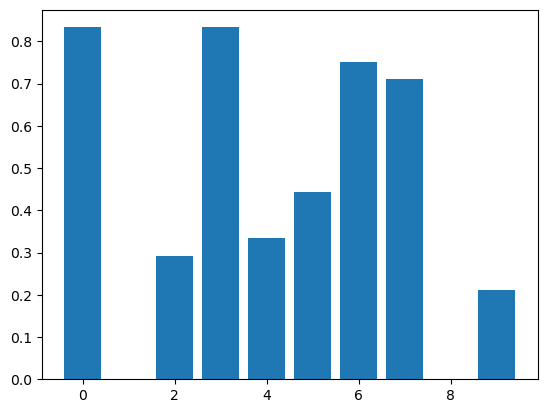

In [42]:
plt.bar(list(pd.DataFrame(reduced).index), d['ohp_all_ever_matchn_30sep2009'])

In [130]:
trial = sample.groupby('ohp_all_ever_matchn_30sep2009')

In [115]:
trial = trial[top_feat].agg('mean')

In [116]:
trial['hhsize_0m']

ohp_all_ever_matchn_30sep2009
0    433.710541
1      3.044233
Name: hhsize_0m, dtype: float32

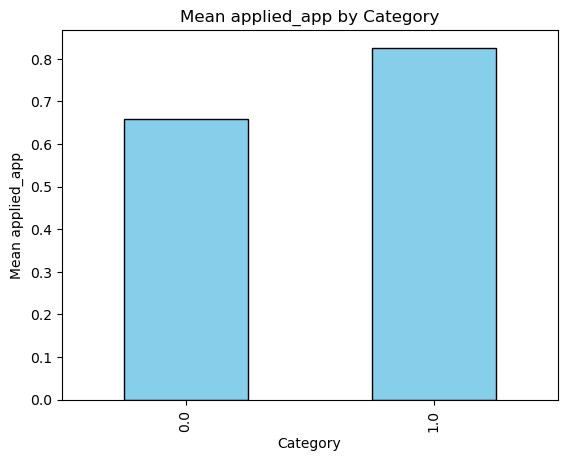

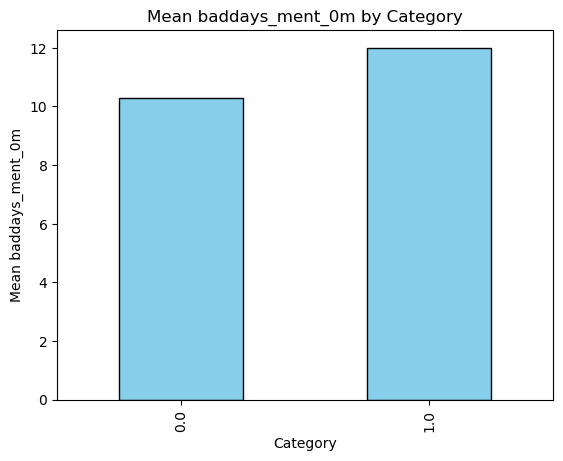

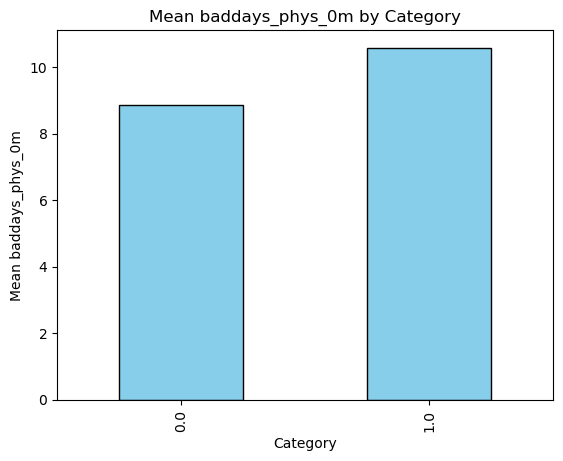

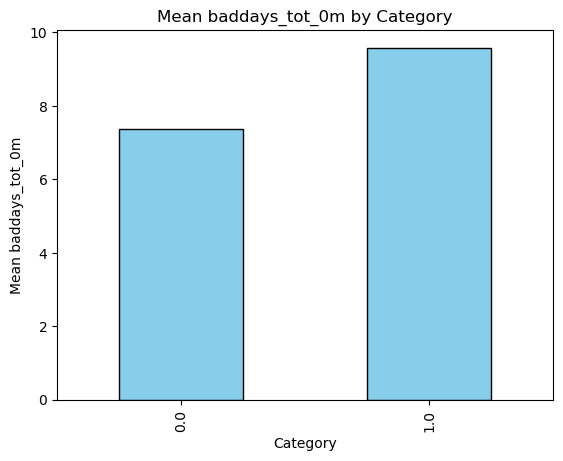

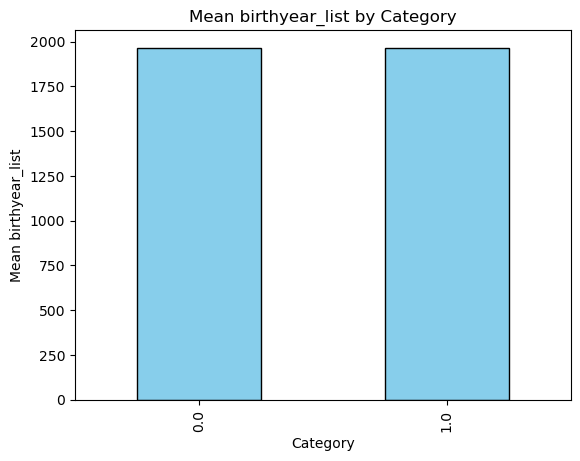

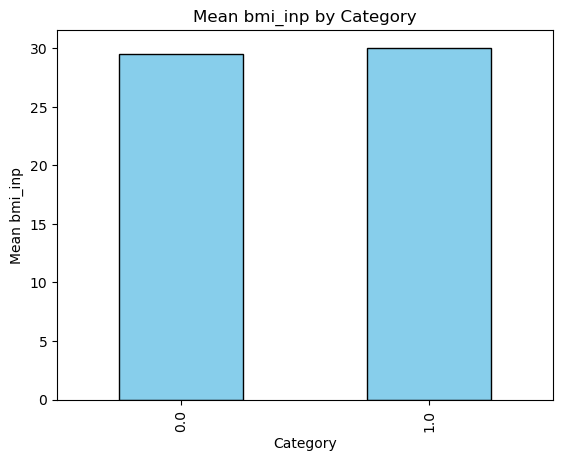

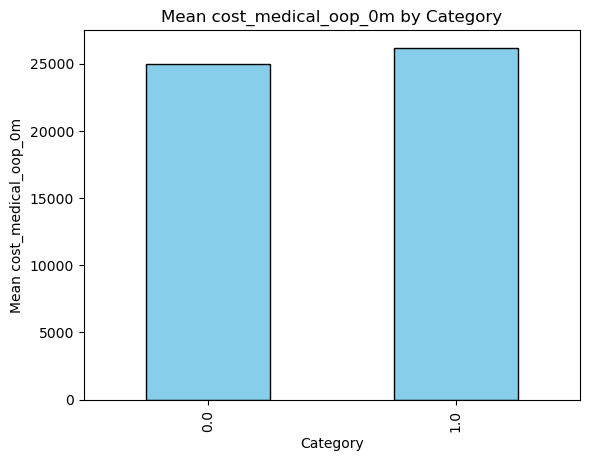

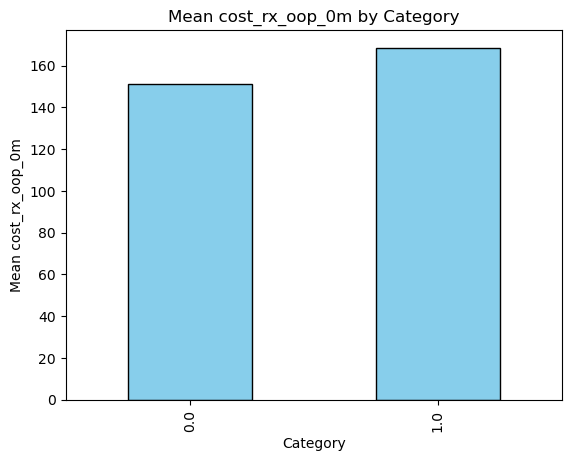

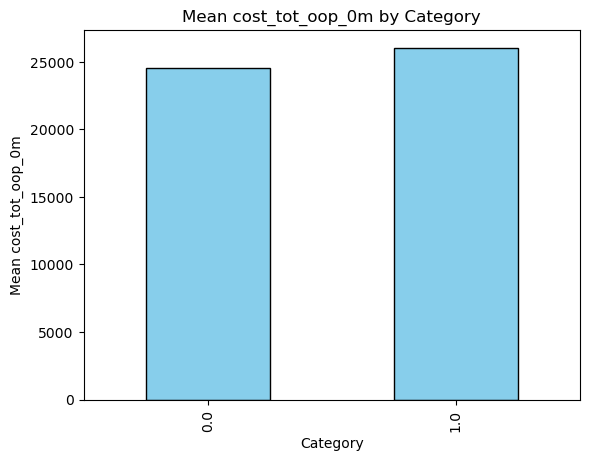

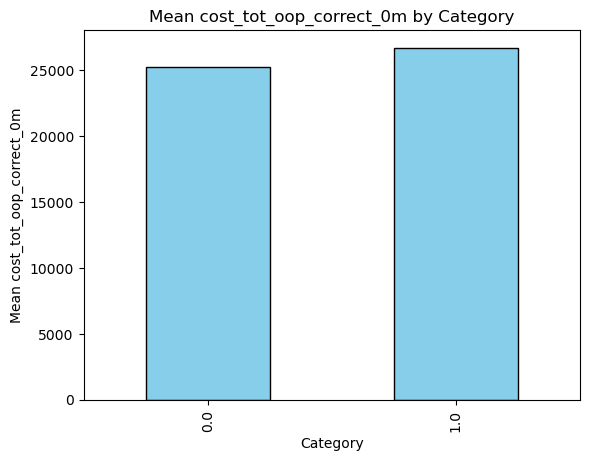

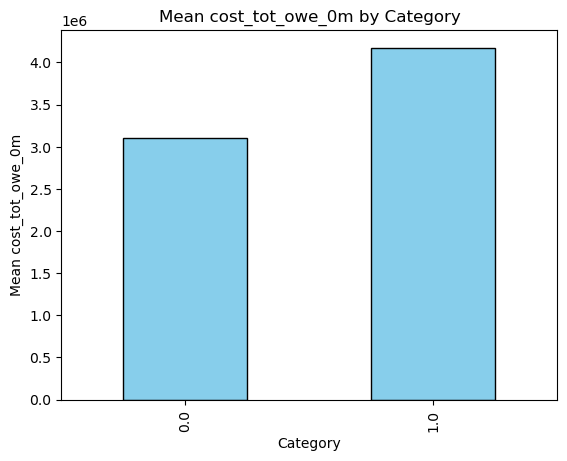

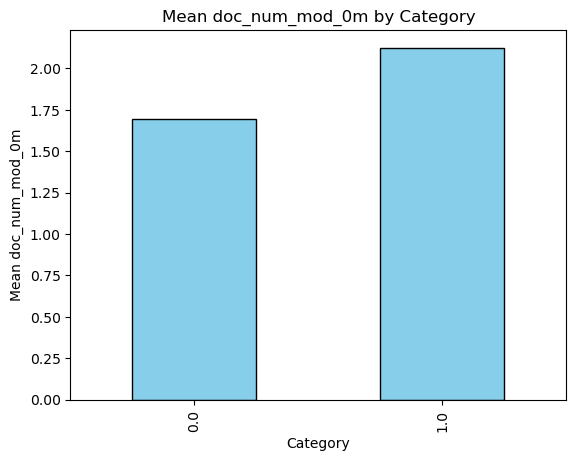

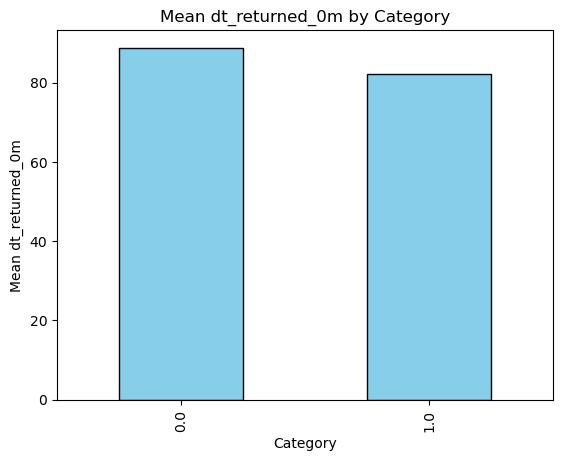

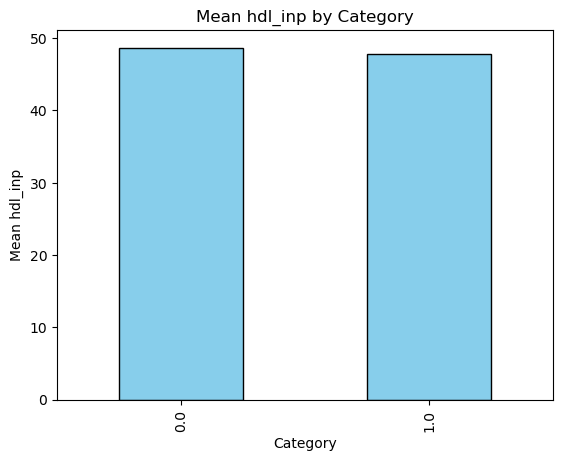

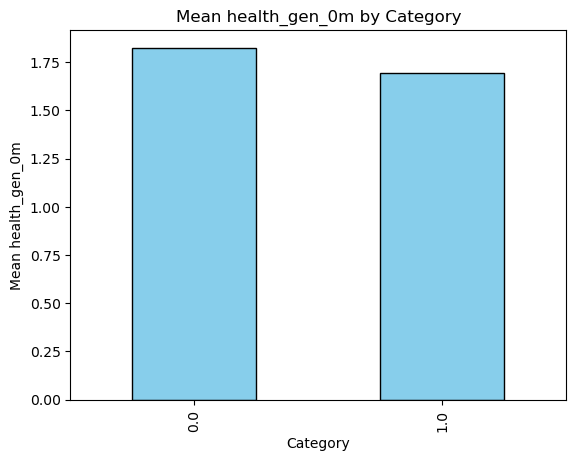

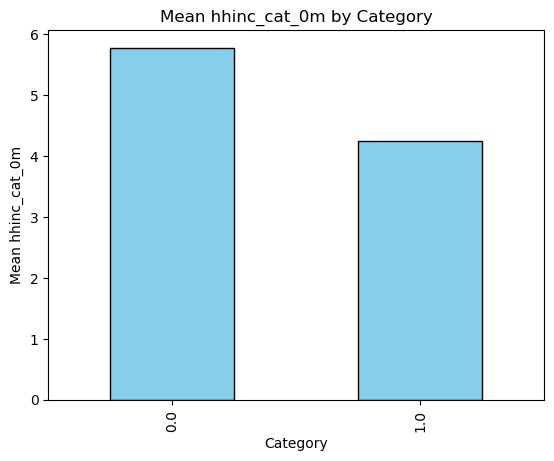

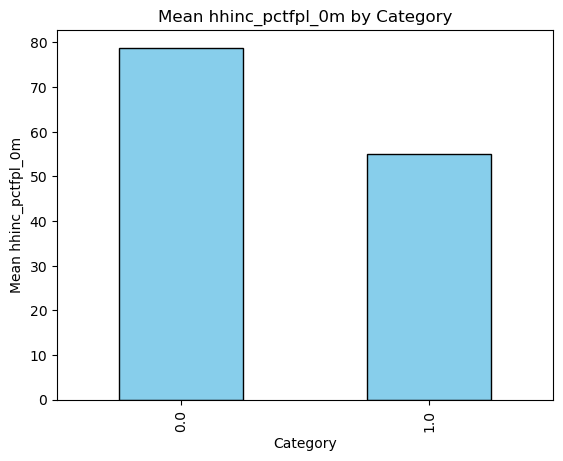

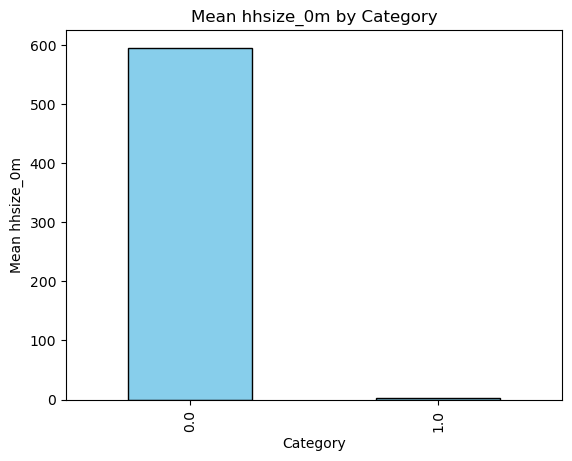

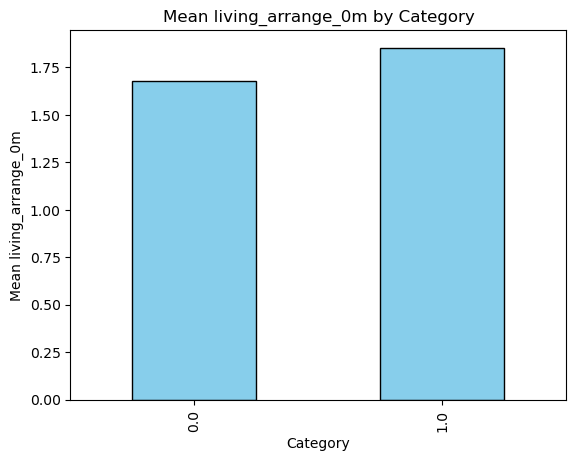

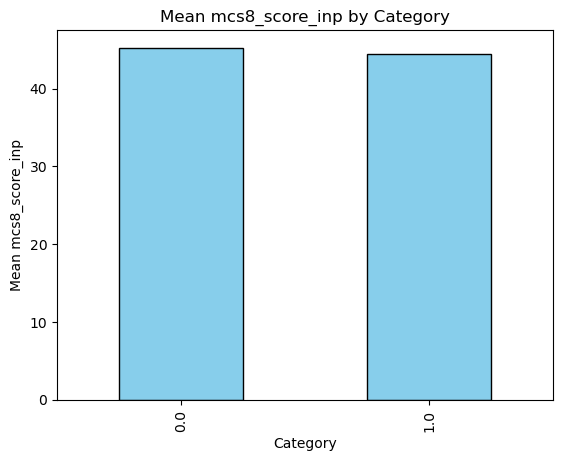

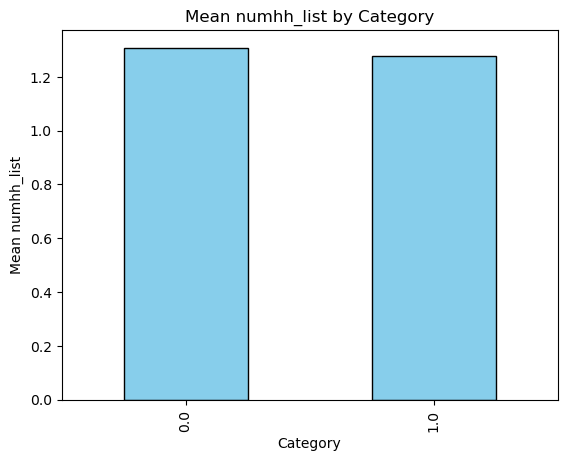

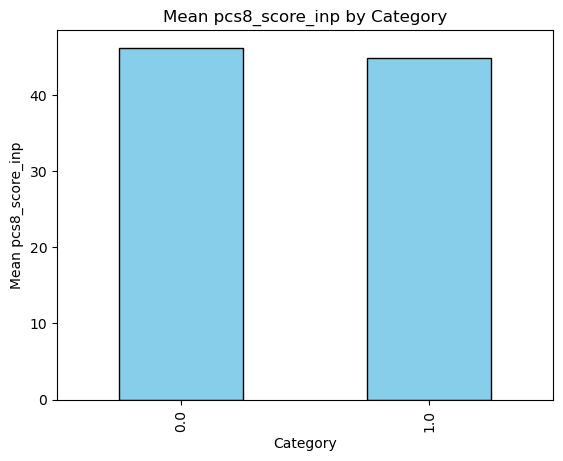

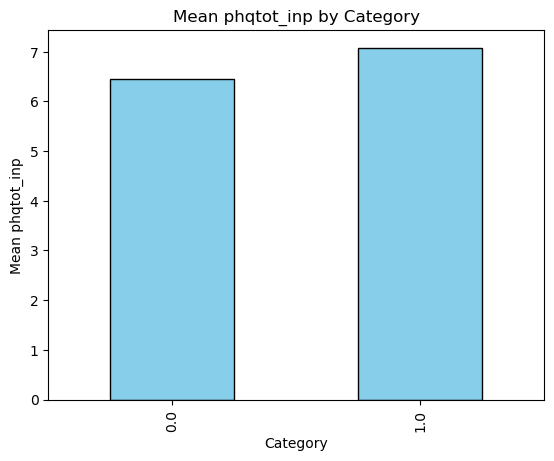

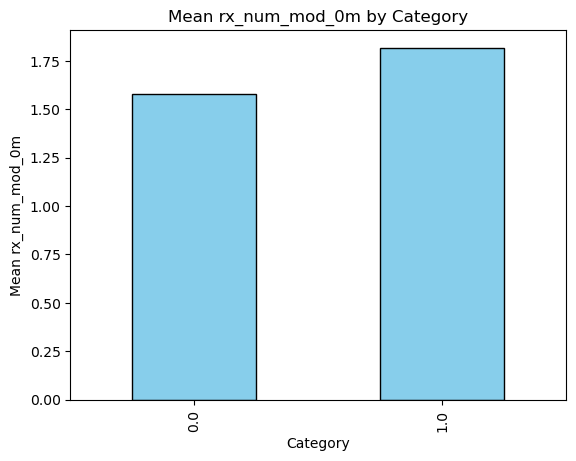

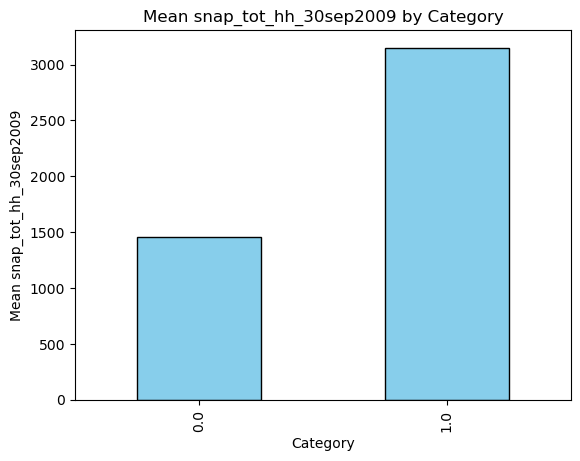

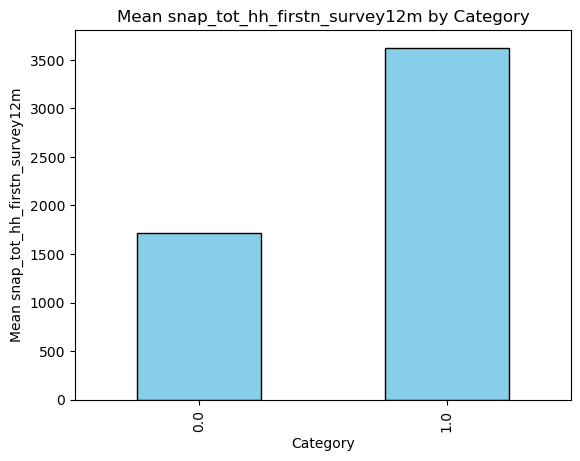

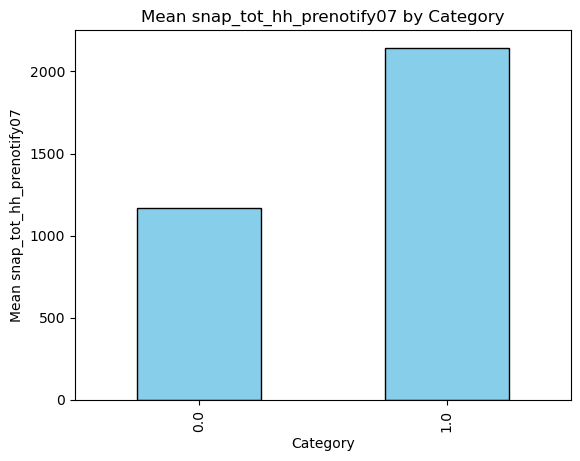

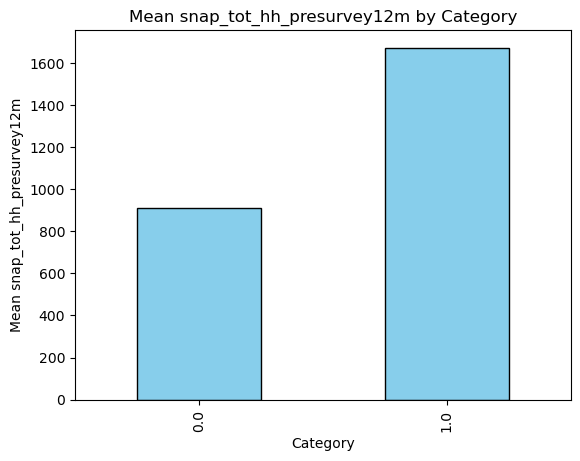

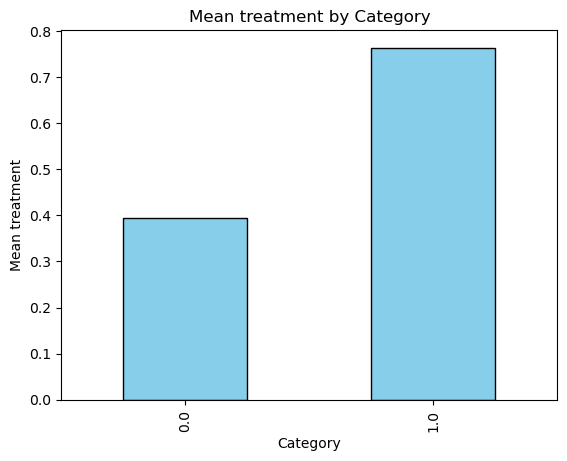

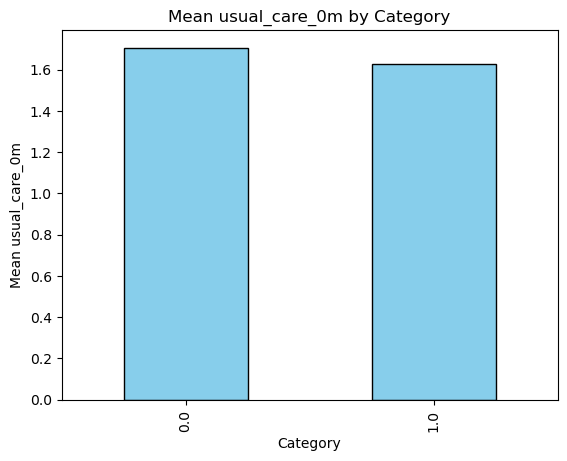

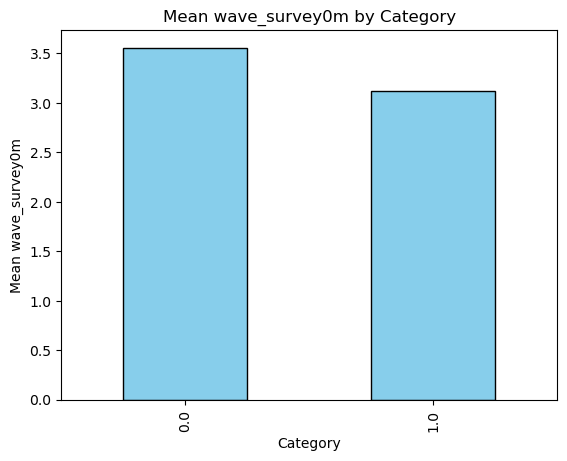

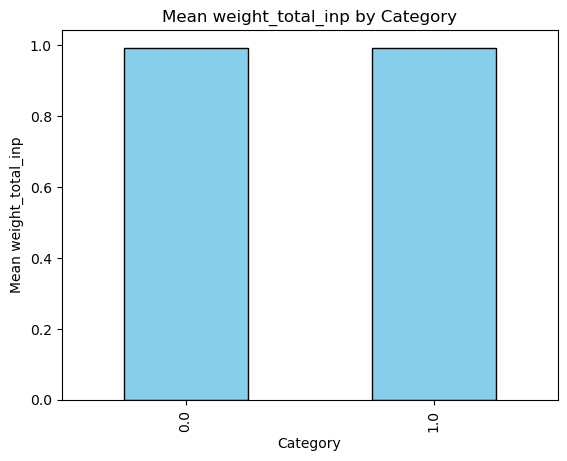

In [111]:
for name in top_feat:
    trial[name].plot(kind='bar', color='skyblue', edgecolor='black')
    plt.xlabel('Category')
    plt.ylabel(f'Mean {name}')
    plt.title(f'Mean {name} by Treatment')
    plt.show()


## KNN on sample

In [43]:
round(sample.isna().sum()/len(sample)*100,2)

person_id                         0.00
household_id                      0.00
ohp_all_ever_matchn_30sep2009     0.00
happiness_12m                     1.37
health_gen_bin_12m                1.60
health_chg_bin_12m                1.41
baddays_phys_12m                  9.93
baddays_ment_12m                  9.01
health_work_12m                   1.76
dep_interest_12m                  1.75
dep_sad_12m                       1.56
cost_any_oop_12m                  1.33
cost_tot_oop_12m                  4.25
cost_any_owe_12m                  1.22
cost_tot_owe_12m                 19.15
cost_borrow_12m                   1.39
cost_refused_12m                  4.93
rx_any_12m                       22.88
rx_num_mod_12m                   22.93
doc_any_12m                       1.05
doc_num_mod_12m                   1.26
er_any_12m                        0.96
er_num_mod_12m                    1.10
hosp_any_12m                      0.71
hosp_num_mod_12m                  0.85
applied_app              

In [44]:
imputer = KNNImputer(n_neighbors=5)
imputed_sample = imputer.fit_transform(sample)

KeyboardInterrupt: 

In [ ]:
round(isample.isna().sum()/len(sample)*100,2)

In [ ]:
isample = pd.DataFrame(imputed_sample)

In [ ]:
isample.columns = sample.columns

In [ ]:
# isample.to_csv('imputed_sample.csv', index = False)

In [ ]:
isample

# Causal Forest drop NA

In [45]:
df = sample.dropna(subset = (outcomes + top_feat + ['ohp_all_ever_matchn_30sep2009']) )

Y = df[outcomes]

X = df[['ohp_all_ever_matchn_30sep2009'] + top_feat]


X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

T_train = X_train.iloc[:,0]
T_test = X_test.iloc[:,0]

X_train = X_train.iloc[:,1:len(X.columns)]
X_test = X_test.iloc[:,1:len(X.columns)]



In [67]:
est = CausalForestDML(model_y=RandomForestRegressor(),
                      model_t=RandomForestClassifier(),
                      criterion='mse', n_estimators=1000,
                      min_impurity_decrease=0.001, cv = 5, discrete_treatment=True, discrete_outcome=False)

est.fit(Y_train, T_train, X =X_train)

In [68]:
est.ate_

array([[-1.63348611e-02],
       [-4.03535075e-02],
       [-5.29042785e-02],
       [ 6.25569392e-01],
       [-1.24513179e-01],
       [ 3.56897269e-03],
       [-8.25831124e-02],
       [-3.50876117e-02],
       [-1.72465056e-01],
       [-4.69114714e+02],
       [-5.19466740e-02],
       [-1.44845356e+03],
       [-1.49557080e-02],
       [-1.39536678e-02],
       [-1.19520751e-02],
       [ 1.87226334e-01],
       [ 2.49755560e-02],
       [ 9.63803942e-01],
       [-4.65834516e-02],
       [-2.44474157e-01],
       [ 3.34255960e-02],
       [ 8.70431723e-02]])

In [73]:
outcomes

['happiness_12m',
 'health_gen_bin_12m',
 'health_chg_bin_12m',
 'baddays_phys_12m',
 'baddays_ment_12m',
 'health_work_12m',
 'dep_interest_12m',
 'dep_sad_12m',
 'cost_any_oop_12m',
 'cost_tot_oop_12m',
 'cost_any_owe_12m',
 'cost_tot_owe_12m',
 'cost_borrow_12m',
 'cost_refused_12m',
 'rx_any_12m',
 'rx_num_mod_12m',
 'doc_any_12m',
 'doc_num_mod_12m',
 'er_any_12m',
 'er_num_mod_12m',
 'hosp_any_12m',
 'hosp_num_mod_12m']

In [69]:
est2 = CausalForestDML(model_y=RandomForestRegressor(),
                      model_t=RandomForestClassifier(),
                      criterion='het', n_estimators=1000,
                      min_impurity_decrease=0.001, cv = 5,discrete_treatment=True, discrete_outcome=False)

est2.fit(Y_train, T_train, X =X_train)

In [71]:
est2.ate_

array([[ 1.41881207e-02],
       [-2.34670305e-04],
       [-4.91585017e-02],
       [ 9.21514301e-01],
       [-3.51442641e-01],
       [ 2.80796981e-02],
       [-6.12158375e-02],
       [-5.47207201e-02],
       [-6.26814125e-02],
       [-1.31131026e+02],
       [ 4.32124353e-02],
       [-1.29471557e+03],
       [ 1.00560237e-01],
       [-3.53692791e-03],
       [-7.97674274e-02],
       [ 8.50668982e-02],
       [ 1.04011953e-01],
       [ 9.13056911e-01],
       [-6.43781786e-03],
       [-1.58621292e-01],
       [ 3.74074191e-02],
       [ 9.35935470e-02]])

In [74]:
import shap

In [82]:
shap_values = est2.shap_values(X)

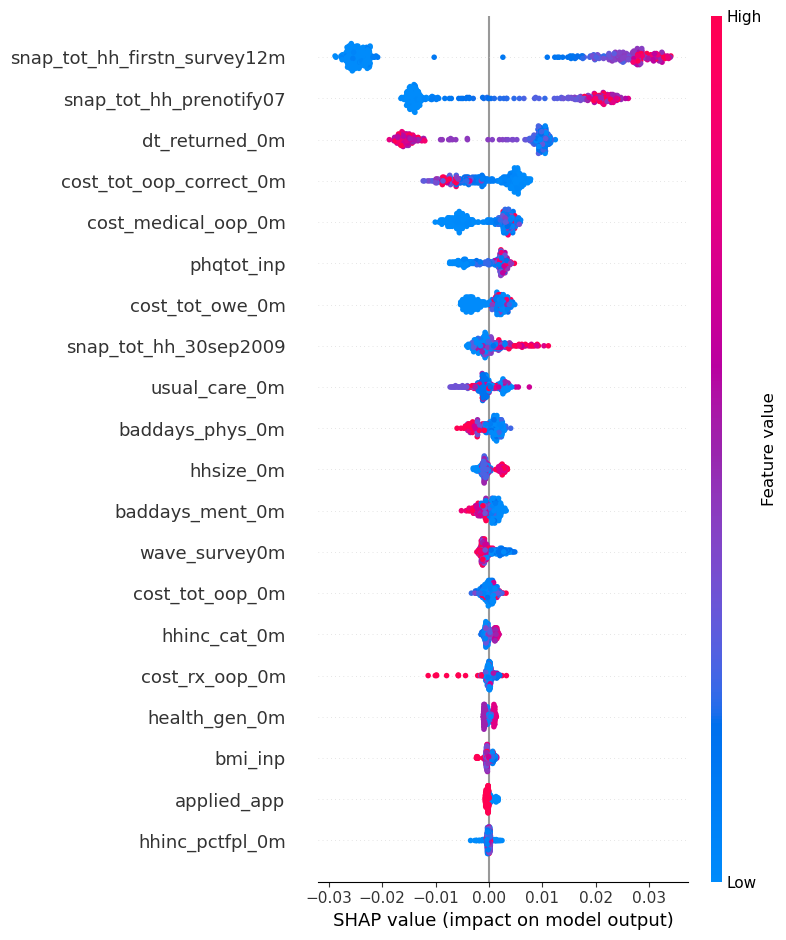

In [80]:
shap.summary_plot(shap_values[outcomes[2]]['ohp_all_ever_matchn_30sep2009_1'])

In [175]:
np.set_printoptions(suppress = True)

some = pd.DataFrame(outcomes)

some['ate'] = np.round(est2.ate_,5)

t_statistic1 = est2.ate_ / est2.ate_stderr_
degrees_of_freedom = len(outcomes) - 1
p_value1 = 2 * (1 - stats.t.cdf(abs(t_statistic1), df=degrees_of_freedom))

alpha = 0.05


s2['ate'] = est2.ate_
s2['stderr'] = est2.ate_stderr_
s2['pvalue'] = p_value1
s2['Significant'] = p_value1 < 0.05



In [177]:
s2.to_csv("na_results.csv")

In [178]:
s2

,0,ate,stderr,pvalue,Significant
0,happiness_12m,0.014188,0.021107,5.087794e-01,False
1,health_gen_bin_12m,-0.000235,0.015906,9.883678e-01,False
2,health_chg_bin_12m,-0.049159,0.010927,1.971188e-04,True
3,baddays_phys_12m,0.921514,0.356431,1.725878e-02,True
4,baddays_ment_12m,-0.351443,0.324265,2.907352e-01,False
5,health_work_12m,0.028080,0.015155,7.800877e-02,False
6,dep_interest_12m,-0.061216,0.035044,9.527569e-02,False
7,dep_sad_12m,-0.054721,0.039256,1.779140e-01,False
8,cost_any_oop_12m,-0.062681,0.037666,1.109335e-01,False
9,cost_tot_oop_12m,-131.131026,89.923218,1.595649e-01,False


In [84]:
treatment_effect = est2.effect(X_test)


In [85]:
maybe = pd.DataFrame(treatment_effect)

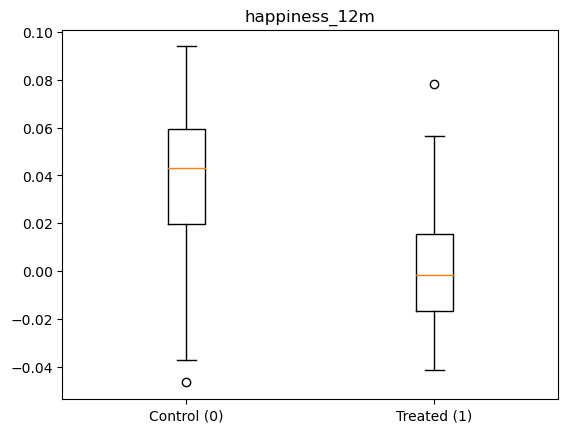

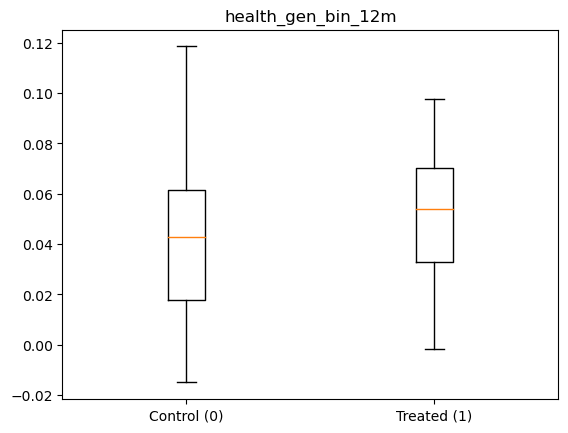

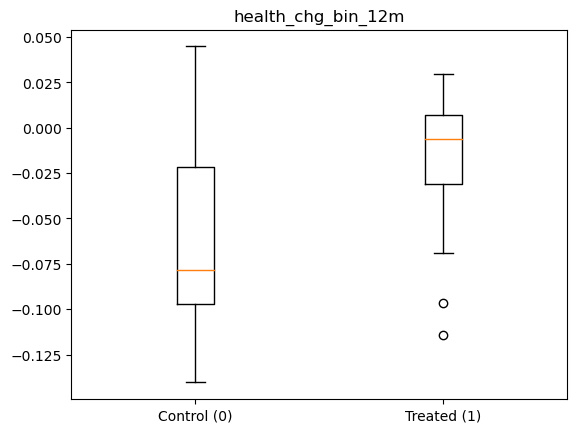

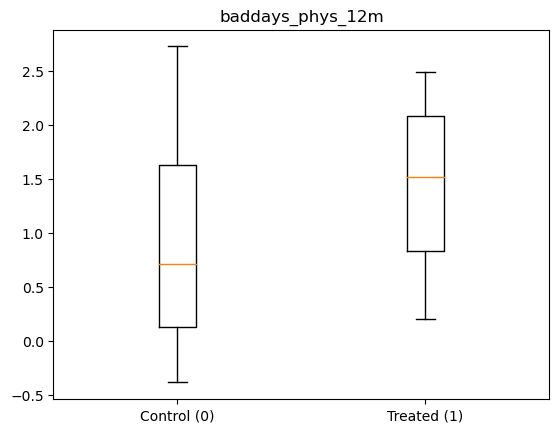

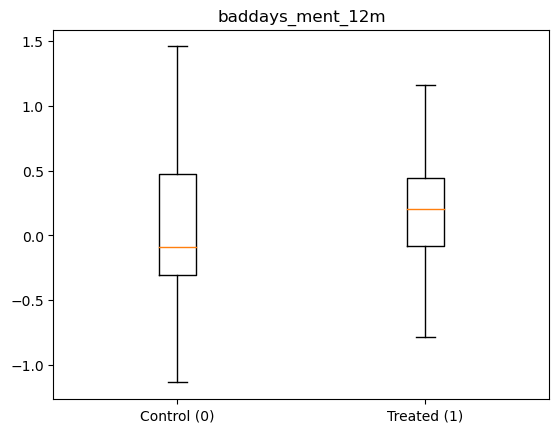

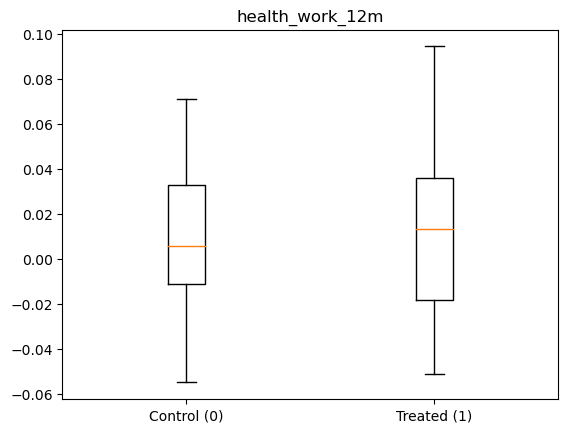

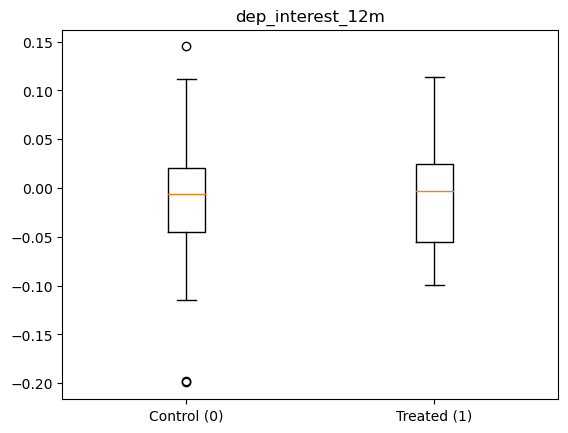

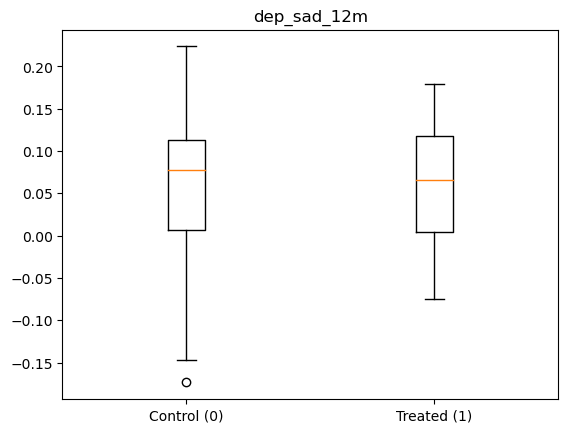

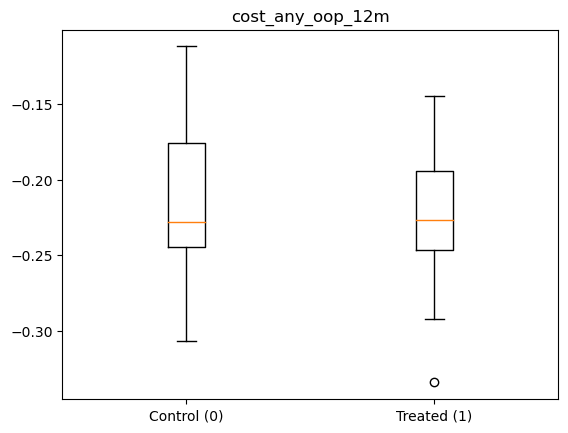

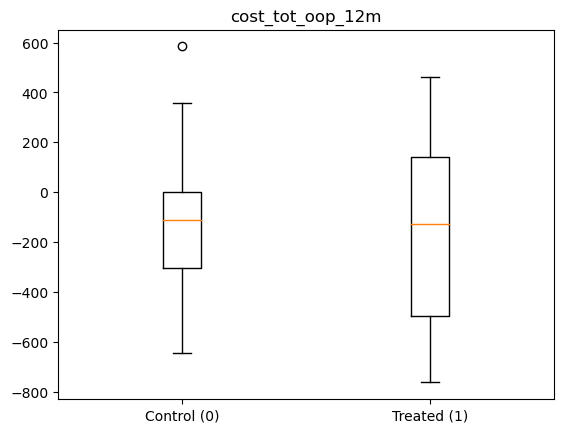

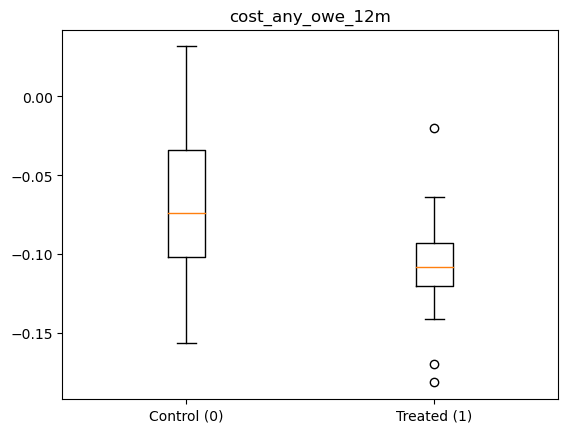

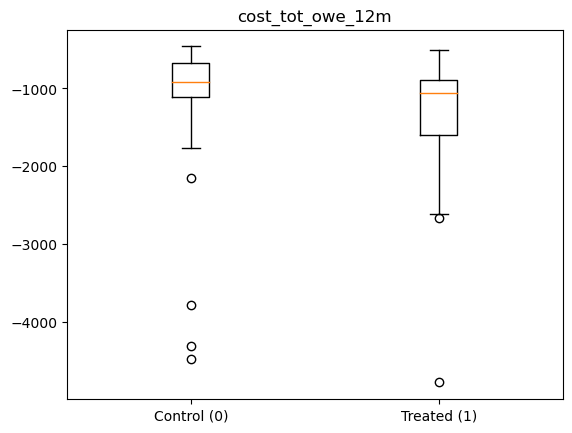

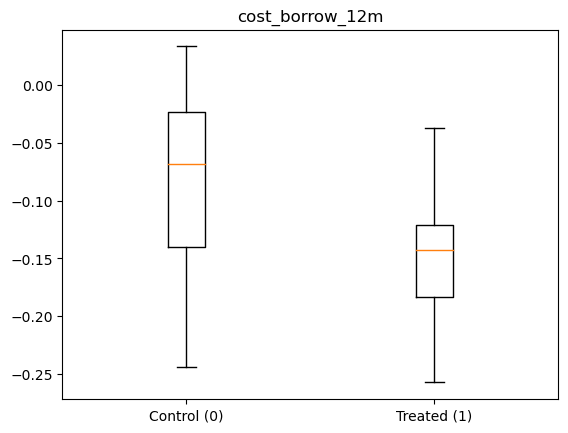

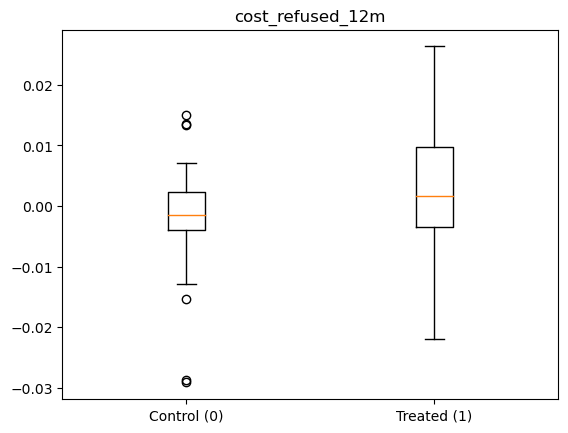

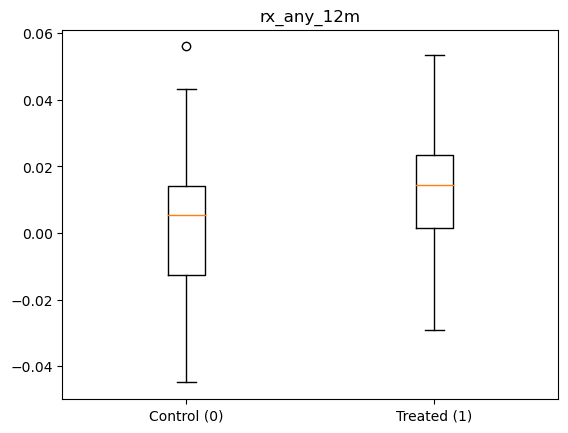

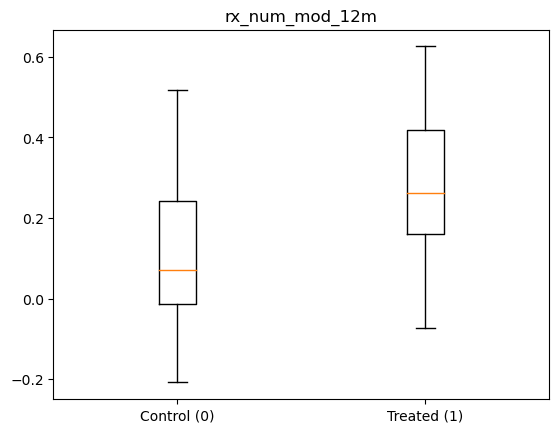

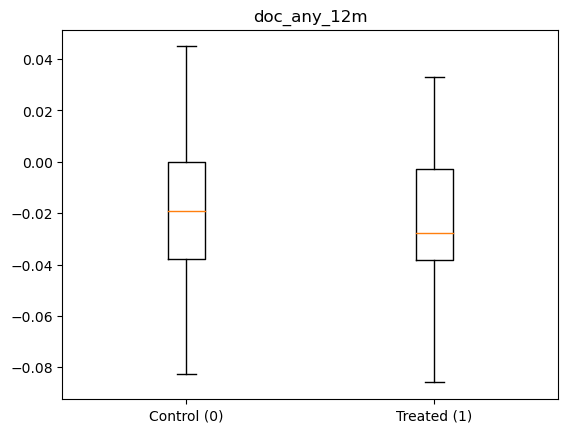

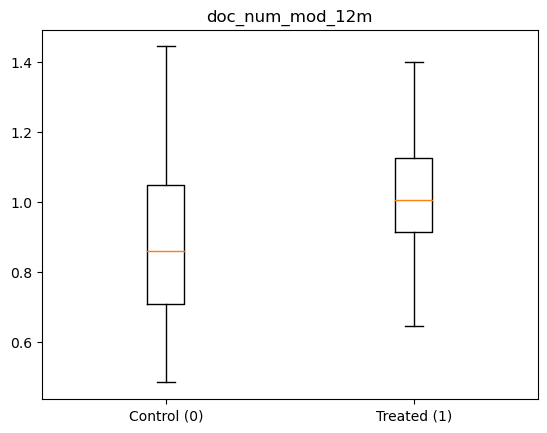

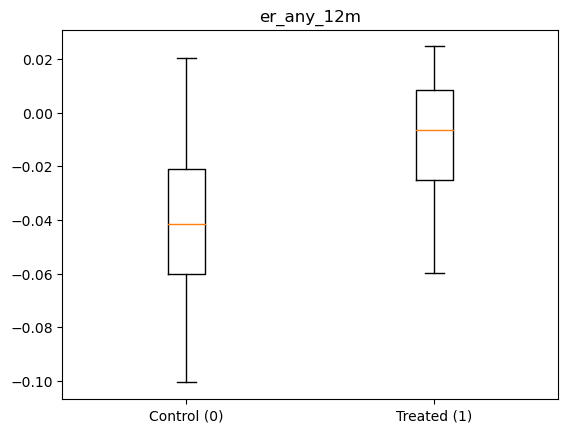

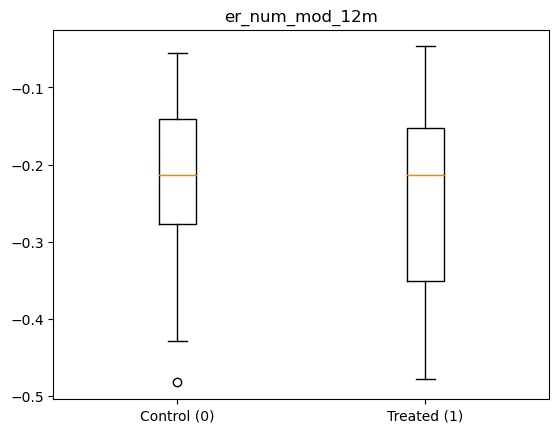

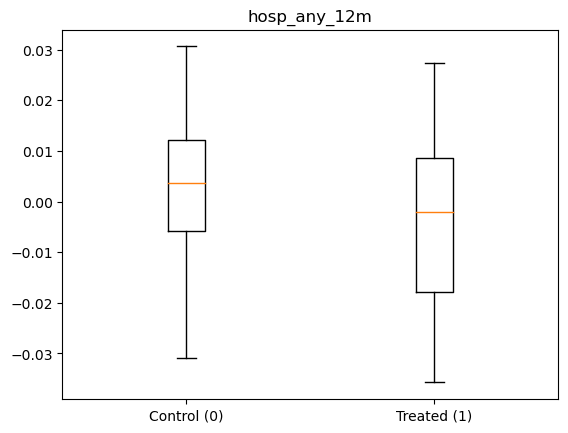

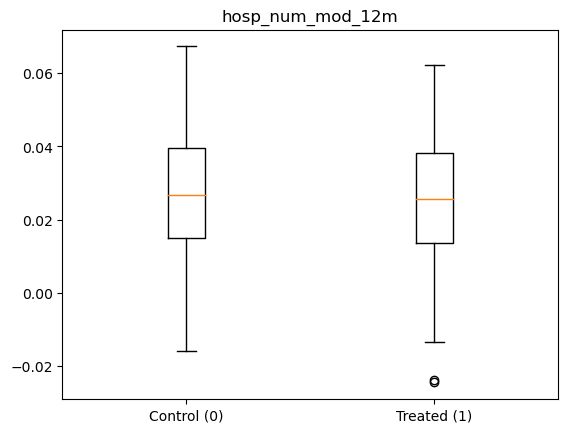

In [86]:
for i in maybe.columns:
    plt.figure()
    plt.boxplot([ maybe.iloc[list(T_test == 0), i], maybe.iloc[list(T_test == 1), i]], labels=[ 'Control (0)','Treated (1)'])
    plt.title(outcomes[i])
    plt.show()

## Causal with KNN

In [120]:
df = pd.read_csv(r'imputed_sample.csv')

In [121]:
df = df.drop(columns = 'hhsize_0m')

In [127]:
top_feat

['applied_app',
 'baddays_ment_0m',
 'baddays_phys_0m',
 'baddays_tot_0m',
 'birthyear_list',
 'bmi_inp',
 'cost_medical_oop_0m',
 'cost_rx_oop_0m',
 'cost_tot_oop_0m',
 'cost_tot_oop_correct_0m',
 'cost_tot_owe_0m',
 'doc_num_mod_0m',
 'dt_returned_0m',
 'hdl_inp',
 'health_gen_0m',
 'hhinc_cat_0m',
 'hhinc_pctfpl_0m',
 'living_arrange_0m',
 'mcs8_score_inp',
 'numhh_list',
 'pcs8_score_inp',
 'phqtot_inp',
 'rx_num_mod_0m',
 'snap_tot_hh_30sep2009',
 'snap_tot_hh_firstn_survey12m',
 'snap_tot_hh_prenotify07',
 'snap_tot_hh_presurvey12m',
 'treatment',
 'usual_care_0m',
 'wave_survey0m',
 'weight_total_inp']

In [126]:
top_feat.remove('hhsize_0m')

In [128]:
Y = df[outcomes]

X = df[['ohp_all_ever_matchn_30sep2009'] + top_feat]


X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

T_train = X_train.iloc[:,0]
T_test = X_test.iloc[:,0]

X_train = X_train.iloc[:,1:len(X.columns)]
X_test = X_test.iloc[:,1:len(X.columns)]

In [129]:
est1 = CausalForestDML(model_y=RandomForestRegressor(),
                      model_t=RandomForestClassifier(),
                      criterion='het', n_estimators=1000,
                      min_impurity_decrease=0.001, cv = 5, discrete_outcome=False,discrete_treatment= True)

est1.fit(Y_train, T_train, X =X_train)

15516    0.0
22043    1.0
16384    1.4
6821     2.0
19073    0.0
        ... 
9495     1.0
889      2.0
6072     1.0
5981     2.0
21507    2.0
Name: happiness_12m, Length: 18992, dtype: float64

In [201]:
est3 = CausalForestDML(model_y=RandomForestRegressor(),
                      model_t=RandomForestClassifier(),
                      criterion='het', n_estimators=1000,
                      min_impurity_decrease=0.001, cv = 5, discrete_outcome=False,discrete_treatment= True)

est3.fit(Y_train['happiness_12m'], T_train, X =X_train)

In [214]:
est3.ate_

array([-0.06302033])

In [221]:
est3.ate_interval(X_test)

(-0.2562036597837965, 0.06980901209499331)

In [183]:
est3.effect_inference(X_test)

KeyboardInterrupt: 

In [143]:
est1.ate_

array([[-5.14289011e-02],
       [-6.24454984e-03],
       [-2.02341481e-02],
       [ 7.94229974e-01],
       [ 4.47747128e-01],
       [ 9.00514561e-02],
       [ 5.53569082e-02],
       [ 4.39385447e-02],
       [-9.86236850e-02],
       [-2.65639260e+03],
       [-5.91083290e-02],
       [ 2.63042726e+09],
       [-9.18213835e-02],
       [-2.02526167e-02],
       [ 8.99434244e-02],
       [ 5.63424340e-01],
       [ 1.97690914e-01],
       [ 1.16298430e+00],
       [ 6.13383593e-02],
       [ 1.65849310e-01],
       [ 6.18251005e-02],
       [ 1.06671194e-01]])

In [132]:
treatment_effect2 = est1.effect(X_test)

In [187]:
outcomes

['happiness_12m',
 'health_gen_bin_12m',
 'health_chg_bin_12m',
 'baddays_phys_12m',
 'baddays_ment_12m',
 'health_work_12m',
 'dep_interest_12m',
 'dep_sad_12m',
 'cost_any_oop_12m',
 'cost_tot_oop_12m',
 'cost_any_owe_12m',
 'cost_tot_owe_12m',
 'cost_borrow_12m',
 'cost_refused_12m',
 'rx_any_12m',
 'rx_num_mod_12m',
 'doc_any_12m',
 'doc_num_mod_12m',
 'er_any_12m',
 'er_num_mod_12m',
 'hosp_any_12m',
 'hosp_num_mod_12m']

In [186]:
pd.DataFrame(treatment_effect2)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-0.134273,-0.021591,-0.015665,0.672797,0.430698,0.070961,0.091348,0.017249,-0.104530,-733.731805,...,-0.112025,-0.028814,0.095059,0.456474,0.215491,1.008154,0.080824,0.248565,0.042178,0.076933
1,-0.111806,-0.032957,-0.094910,-0.859174,-0.147671,0.114242,-0.031166,-0.045735,-0.145075,10059.199051,...,-0.176394,-0.051791,0.018774,0.305032,0.079334,0.103762,0.046929,0.114182,0.046159,0.041859
2,-0.083814,-0.053458,-0.028879,-0.055741,0.039647,0.045826,-0.033330,0.018474,-0.110147,2024.354958,...,-0.061987,-0.026963,0.054004,0.244274,0.205335,1.270998,0.047688,0.110181,0.040943,0.062279
3,-0.165658,-0.029368,-0.036636,0.386859,-0.165846,0.107945,0.044708,-0.020309,-0.040983,-280.068188,...,-0.086741,-0.030948,0.110272,0.539787,0.256483,1.318891,0.056782,0.169257,0.043540,0.086661
4,-0.118405,-0.029118,-0.028501,0.519178,0.226248,0.132242,0.144198,0.082333,-0.099187,-2878.578265,...,-0.137197,-0.046735,0.048168,0.434792,0.164801,1.503606,0.062468,0.107480,0.056659,0.085899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744,-0.104970,-0.024251,-0.029231,1.612607,0.193967,0.110451,0.103585,-0.017768,-0.110327,-189.802110,...,-0.131945,-0.026871,0.067038,0.686538,0.117357,0.578939,0.075284,0.193399,0.048993,0.083474
4745,-0.087393,-0.077017,-0.017259,-0.299539,-0.339832,0.073725,-0.047912,-0.007548,-0.150149,-2569.827193,...,-0.128022,-0.029379,0.059539,0.410688,0.168781,1.158943,0.051265,0.073919,0.037881,0.058396
4746,-0.093629,-0.054271,-0.024121,0.888417,-0.708547,0.085601,-0.018157,-0.006396,-0.142319,290.914800,...,-0.085816,-0.027472,0.083642,0.407760,0.161294,0.832178,0.030370,0.070800,0.041491,0.048327
4747,-0.059734,-0.011022,-0.010894,1.610972,0.937715,0.159095,0.024529,0.084806,-0.117867,-3101.511209,...,-0.147156,-0.029353,0.045190,0.557477,0.162779,0.815257,0.058825,0.126673,0.047972,0.085625


In [198]:
outcomes

['happiness_12m',
 'health_gen_bin_12m',
 'health_chg_bin_12m',
 'baddays_phys_12m',
 'baddays_ment_12m',
 'health_work_12m',
 'dep_interest_12m',
 'dep_sad_12m',
 'cost_any_oop_12m',
 'cost_tot_oop_12m',
 'cost_any_owe_12m',
 'cost_tot_owe_12m',
 'cost_borrow_12m',
 'cost_refused_12m',
 'rx_any_12m',
 'rx_num_mod_12m',
 'doc_any_12m',
 'doc_num_mod_12m',
 'er_any_12m',
 'er_num_mod_12m',
 'hosp_any_12m',
 'hosp_num_mod_12m']

In [193]:
np.set_printoptions(suppress = True)
np.round(est1.ate_,5)



array([[-5.14300000e-02],
       [-6.24000000e-03],
       [-2.02300000e-02],
       [ 7.94230000e-01],
       [ 4.47750000e-01],
       [ 9.00500000e-02],
       [ 5.53600000e-02],
       [ 4.39400000e-02],
       [-9.86200000e-02],
       [-2.65639260e+03],
       [-5.91100000e-02],
       [ 2.63042726e+09],
       [-9.18200000e-02],
       [-2.02500000e-02],
       [ 8.99400000e-02],
       [ 5.63420000e-01],
       [ 1.97690000e-01],
       [ 1.16298000e+00],
       [ 6.13400000e-02],
       [ 1.65850000e-01],
       [ 6.18300000e-02],
       [ 1.06670000e-01]])

In [151]:
est1.ate_stderr_

array([[4.23655253e-03],
       [3.10345134e-03],
       [2.55254666e-03],
       [7.45845165e-02],
       [8.06299129e-02],
       [3.02078857e-03],
       [6.65930742e-03],
       [6.16917717e-03],
       [3.20776744e-03],
       [4.53364382e+02],
       [2.95569090e-03],
       [3.85992093e+08],
       [2.79309671e-03],
       [1.94291640e-03],
       [2.46308344e-03],
       [1.72633433e-02],
       [2.97888603e-03],
       [2.11001016e-02],
       [2.79489400e-03],
       [8.00482225e-03],
       [2.49667352e-03],
       [5.27247418e-03]])

In [168]:
np.set_printoptions(suppress = True)

s2 = pd.DataFrame(outcomes)

s2['ate'] = est1.ate_
s2['stderr'] = est1.ate_stderr_
s2['pvalue'] = p_value
s2['Significant'] = p_value < 0.05

In [169]:
s2

,0,ate,stderr,pvalue,Significant
0,happiness_12m,-5.142890e-02,4.236553e-03,5.883583e-11,True
1,health_gen_bin_12m,-6.244550e-03,3.103451e-03,5.720975e-02,False
2,health_chg_bin_12m,-2.023415e-02,2.552547e-03,9.535181e-08,True
3,baddays_phys_12m,7.942300e-01,7.458452e-02,6.373677e-10,True
4,baddays_ment_12m,4.477471e-01,8.062991e-02,1.644122e-05,True
5,health_work_12m,9.005146e-02,3.020789e-03,0.000000e+00,True
6,dep_interest_12m,5.535691e-02,6.659307e-03,4.429360e-08,True
7,dep_sad_12m,4.393854e-02,6.169177e-03,5.035188e-07,True
8,cost_any_oop_12m,-9.862368e-02,3.207767e-03,0.000000e+00,True
9,cost_tot_oop_12m,-2.656393e+03,4.533644e+02,8.137518e-06,True


In [170]:
s2.to_csv('imputed_results.csv')

In [140]:
may = pd.DataFrame(treatment_effect2)

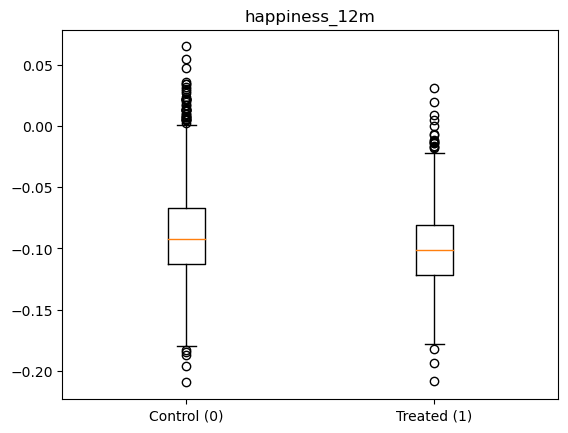

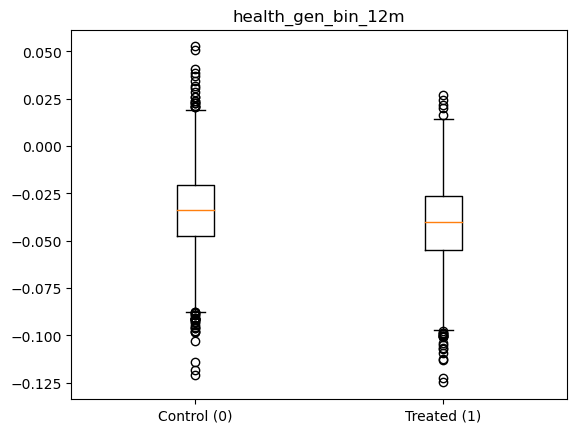

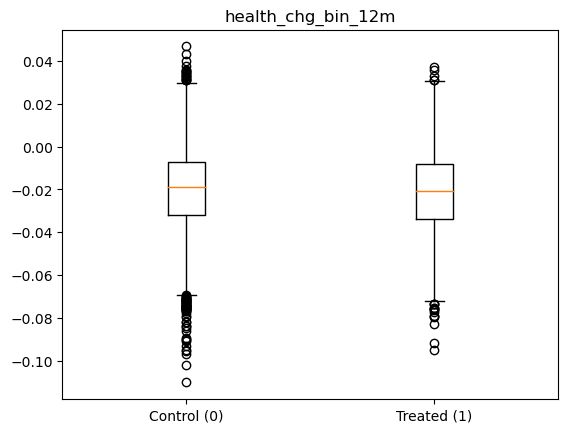

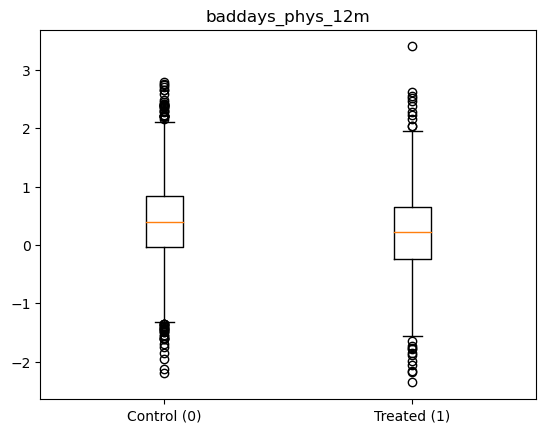

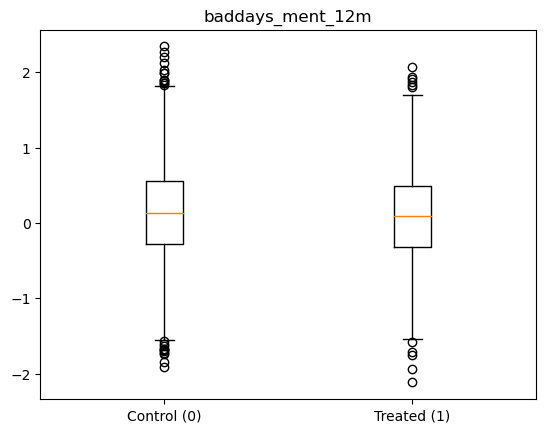

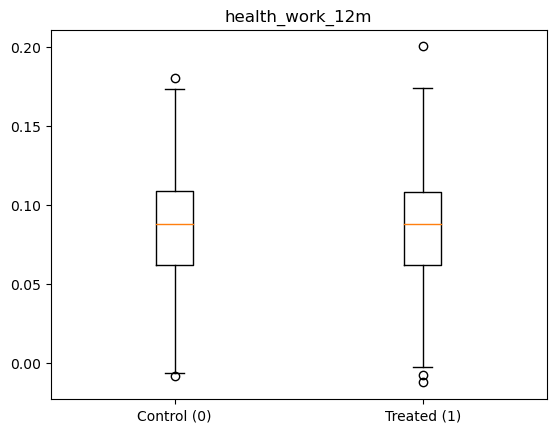

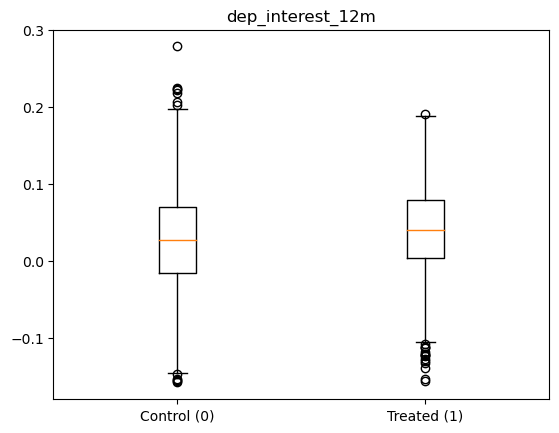

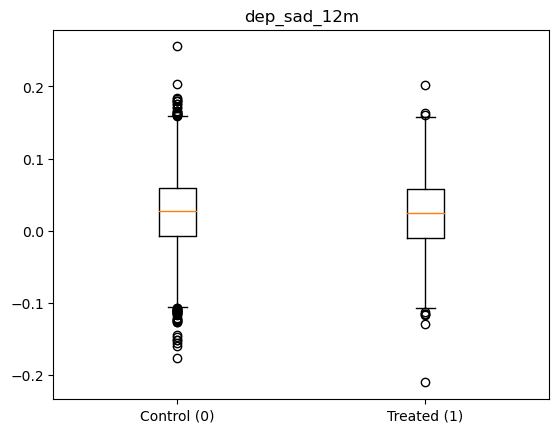

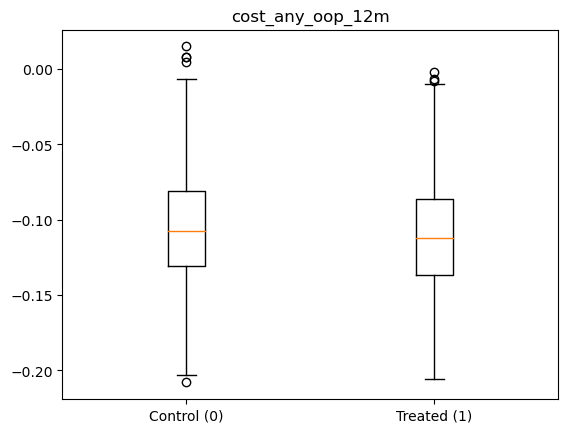

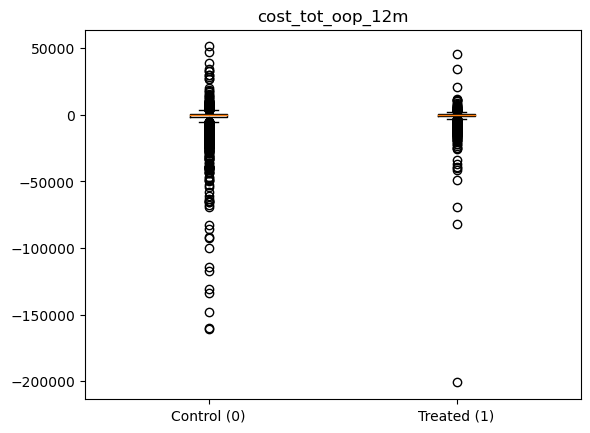

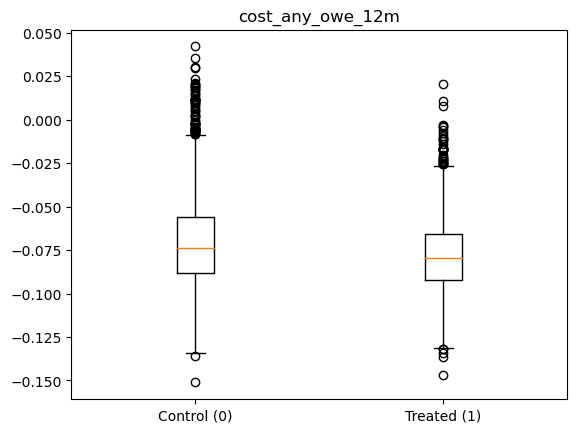

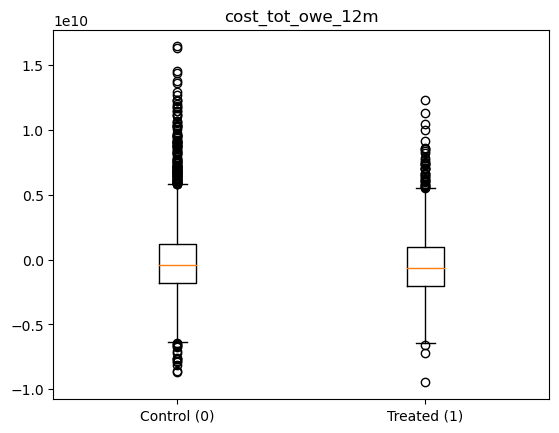

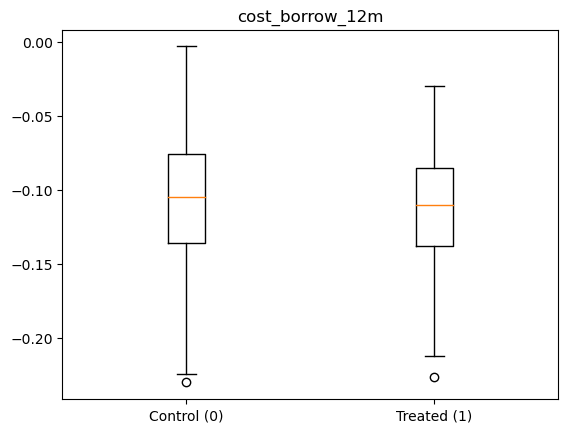

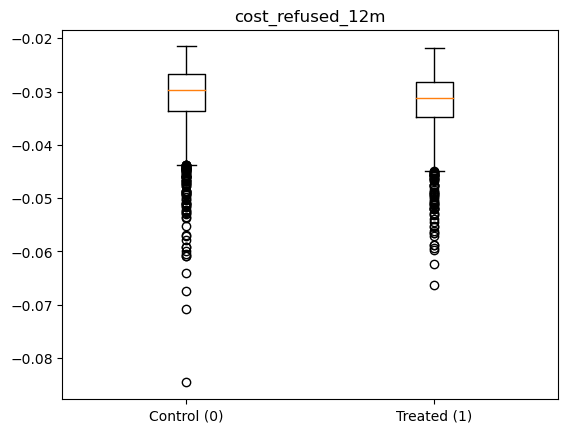

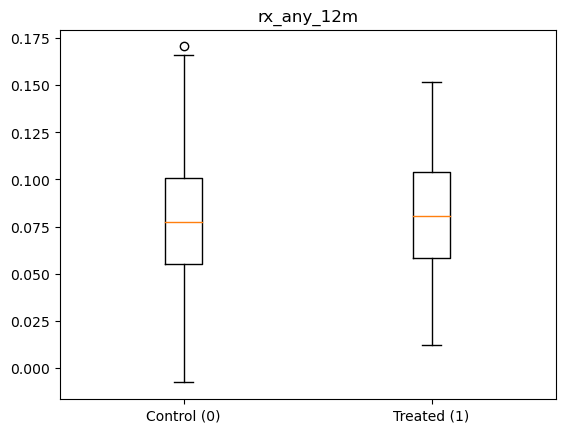

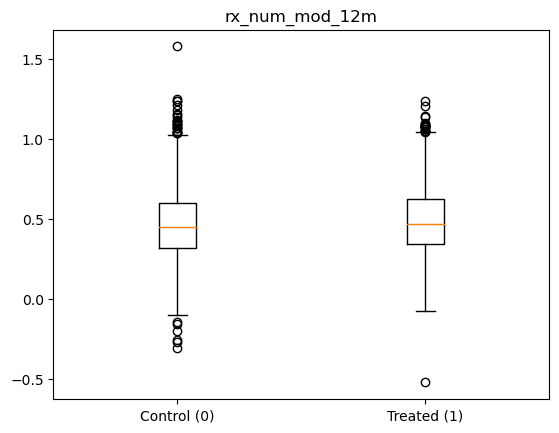

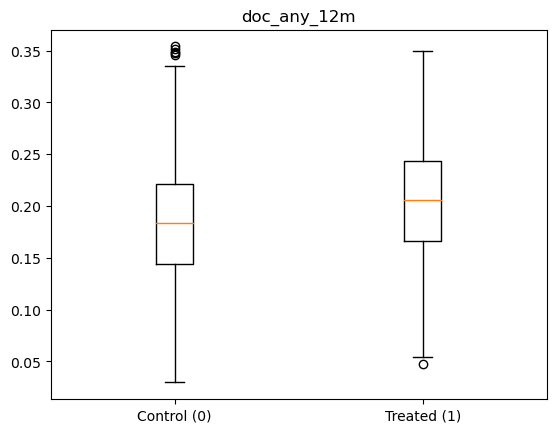

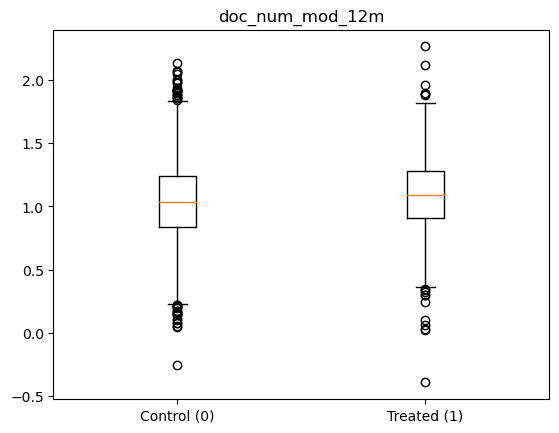

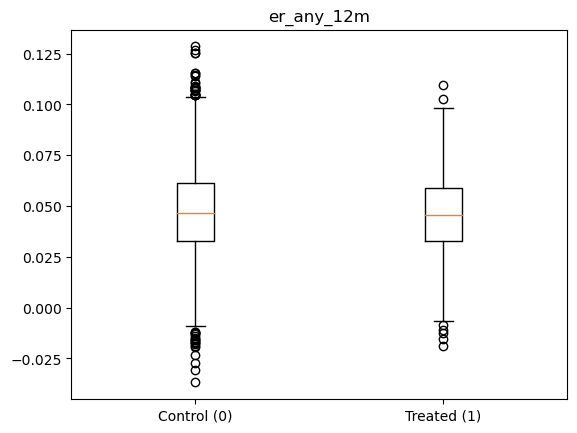

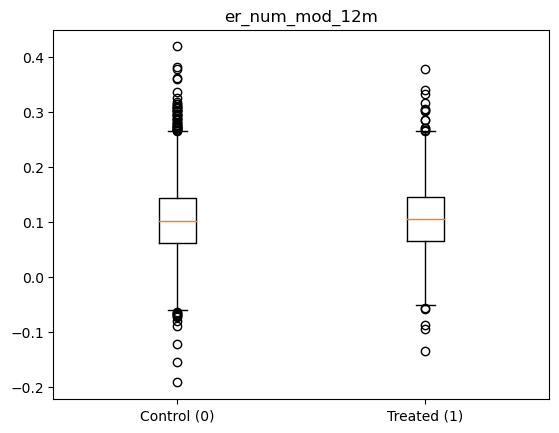

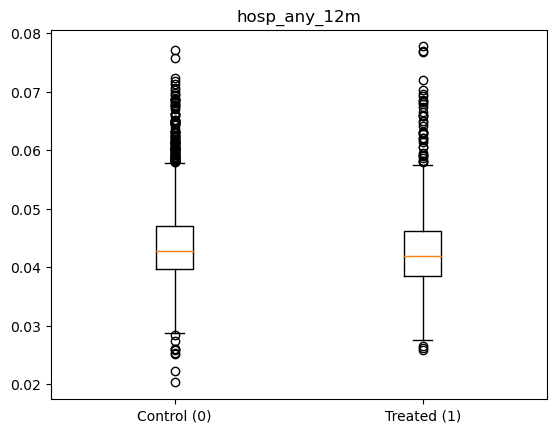

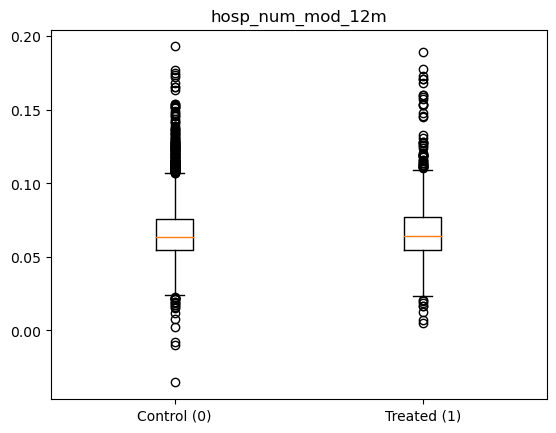

In [141]:
for i in may.columns:
    plt.figure()
    plt.boxplot([ may.iloc[list(T_test == 0), i], may.iloc[list(T_test == 1), i]], labels=[ 'Control (0)','Treated (1)'])
    plt.title(outcomes[i])
    plt.show()

In [152]:
import scipy.stats as stats

# Example value of est1.ate_stderr_ (replace with your actual value)



ate_stderr = 0.02

# Null hypothesis: ATE is zero (not statistically significant)
# Alternative hypothesis: ATE is not zero (statistically significant)

  # Assuming Y_train is the outcome vector

# Calculate the p-value
p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), df=degrees_of_freedom))

# Set significance level (alpha)
alpha = 0.05

# Check if p-value is less than alpha
if p_value < alpha:
    print(f"ATE is statistically significant (p-value = {p_value:.4f})")
else:
    print(f"ATE is not statistically significant (p-value = {p_value:.4f})")


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [180]:
est1.ate_inference()

ValueError: This inference method currently does not support X=None!

In [162]:
t_statistic = est1.ate_ / est1.ate_stderr_
degrees_of_freedom = len(outcomes) - 1
p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), df=degrees_of_freedom))

alpha = 0.05

for p in p_value:
    if p[0] < alpha:
        print(f"ATE is statistically significant (p-value = {p[0]:.4f})")
    else:
        print(f"ATE is not statistically significant (p-value = {p[0]:.4f})")

ATE is statistically significant (p-value = 0.0000)
ATE is not statistically significant (p-value = 0.0572)
ATE is statistically significant (p-value = 0.0000)
ATE is statistically significant (p-value = 0.0000)
ATE is statistically significant (p-value = 0.0000)
ATE is statistically significant (p-value = 0.0000)
ATE is statistically significant (p-value = 0.0000)
ATE is statistically significant (p-value = 0.0000)
ATE is statistically significant (p-value = 0.0000)
ATE is statistically significant (p-value = 0.0000)
ATE is statistically significant (p-value = 0.0000)
ATE is statistically significant (p-value = 0.0000)
ATE is statistically significant (p-value = 0.0000)
ATE is statistically significant (p-value = 0.0000)
ATE is statistically significant (p-value = 0.0000)
ATE is statistically significant (p-value = 0.0000)
ATE is statistically significant (p-value = 0.0000)
ATE is statistically significant (p-value = 0.0000)
ATE is statistically significant (p-value = 0.0000)
ATE is s